# Etude des coûts énergétiques d'une atmosphère tropicale en parc aquatique

### Jupyter Notebook Final S13

***

## 1. Introduction :

Ce projet vise à étudier les coûts énergétiques du parc aquatique Aqualibi pour le maintien d'une atmosphère tropicale à  une température de l'air constante à 29°C et une humidité relative élevée (65%). L'eau de ses piscines est maintenue à une température de 28°C. 

*Remarque :* Nous avons utilisé des données météorologiques mesurées à Louvain-La-Neuve de 1998 à 2020 que nous avons normalisées sur une année type.


In [1]:
#%% Chargement des données :
#Code donné par les assistants 
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 26 10:31:45 2021
 
@author: maxthomas
"""
 
from IPython import get_ipython
get_ipython().magic('reset -sf')
 
# Importing packages
import numpy as np
import numpy.linalg as la
import math as m
 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
import pathlib as pl
current_WD = pl.Path().absolute()
print(current_WD)

data1 = pd.read_csv (f"{current_WD}/weather_data/18_010198_311203_hora.csv",
                       delimiter=';',
                       decimal=',')
data2 = pd.read_csv (f"{current_WD}/weather_data/18_010103_311208_hora.csv",
                       delimiter=';',
                       decimal=',')
data3 = pd.read_csv (f"{current_WD}/weather_data/18_010108_311213_hora.csv",
                       delimiter=';',
                       decimal=',')
data4 = pd.read_csv (f"{current_WD}/weather_data/18_010113_311218_hora.csv",
                       delimiter=';',
                       decimal=',')
data5 = pd.read_csv (f"{current_WD}/weather_data/18_010119_311219_hora.csv",
                       delimiter=';',
                       decimal=',')
data6 = pd.read_csv (f"{current_WD}/weather_data/18_010120_311220_hora.csv",
                       delimiter=';',
                       decimal=',')
 
df = data1.head(0)
df = df.append(data1)
df = df.append(data2)
df = df.append(data3)
df = df.append(data4)
df = df.append(data5)
df = df.append(data6)
 
df.drop_duplicates(subset=None, keep='first', inplace=False)

df['Datetime'] = pd.to_datetime(df['timestamp'],format='%d/%m/%Y-%H:%M:%S')
df = df.set_index('Datetime')
df.loc[df.tsa == -9999,['tsa']] = np.nan
df.loc[df.tsf == -9999,['tsf']] = np.nan
df.loc[df.tss == -9999,['tss']] = np.nan
df.loc[df.plu == -9999,['plu']] = np.nan
df.loc[df.ens == -9999,['ens']] = np.nan
df.loc[df.ens == -9999,['hra']] = np.nan
 
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
 
df = df.sort_values('Datetime')
df[["tsa"]].describe()
 
LLN_weather = df
temperature=LLN_weather['tsa']
pluie=LLN_weather['plu']
ensoleillement=LLN_weather['ens']
humrel = LLN_weather['hra']

### Probleme dans les données :
#testprob = temperature.loc['2006-11-30':'2006-12-01']
#plt.plot(testprob)
#plt.show()

/Users/basiledelvoie/Documents/UCL/BIR13/LBIR1325B/Projet final S13/Remise/P8B-Jupyter_Final


Moyenne température année : 11.112298704849962 °C
Moyenne température été : 17.916965386987368 °C
Moyenne température hiver : 4.561107349664116 °C
Moyenne ensoleillement année : 113.6082176479165 W/m^2
Moyenne ensoleillement été : 173.9677767499227 W/m^2
Moyenne ensoleillement hiver : 34.02650701865679 W/m^2
Moyenne humidité relative année : 82.21080752431966 %
Moyenne humidité relative été : 78.13102836879426 %
Moyenne humidité relative hiver : 89.98642310789052 %
Moyenne humidité absolue année : 7.004895157442503 g eau/kg air
Moyenne humidité absolue été : 9.898006481766402 g eau/kg air
Moyenne humidité absolue hiver : 4.700360532822199 g eau/kg air


/Users/basiledelvoie/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


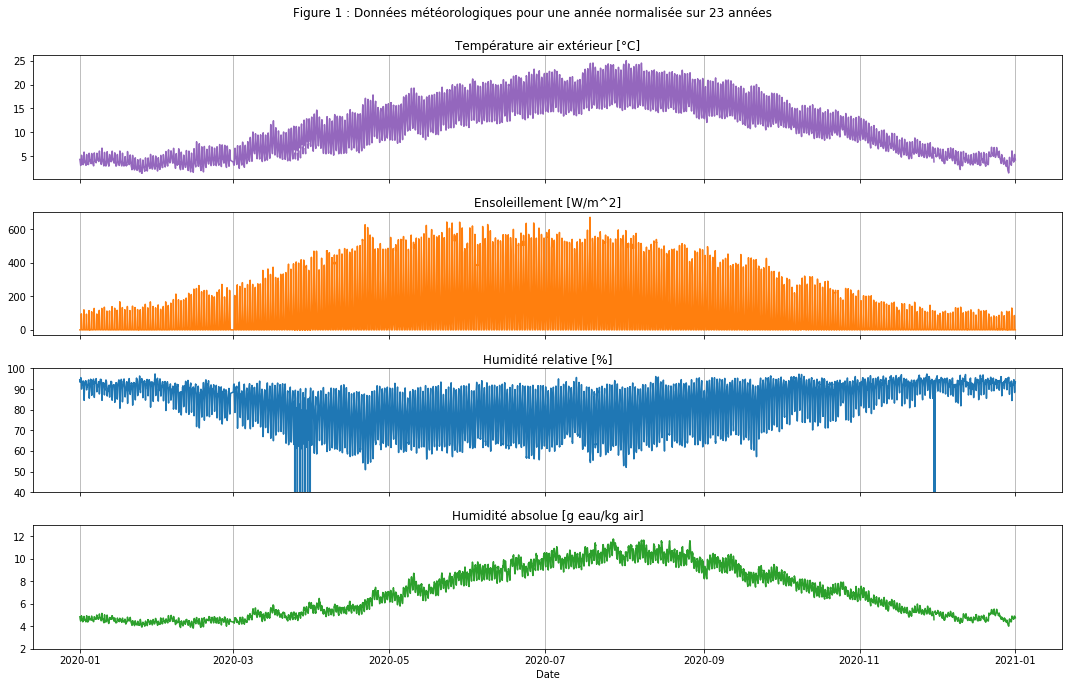

In [2]:
#%% NORMALISATION d'une année-type en faisant les moyennes horaires entre 1998 et 2020 (sans 29 février)
# Credit pour la réalisation de cette cellule de code : Corentin Meeûs

### Création d'un vecteur time sans les 29 févriers pour coller aux variables t_norm, e_norm, h_norm
date=pd.date_range(start ='1-1-2020', end ='1-1-2021', freq ='1H')
annee = pd.DataFrame(data=0, index=date, columns=['time']) #création d'une colonne time pour pouvoir set l'index et la supprimer après
annee.drop(annee.index[8784],0,inplace=True) #ablation dernière ligne qui correspondait à 00:00 du 1er janvier suivant
annee.drop(annee.index[1416:1440],0,inplace=True) #ablation des 24h qui correspondaient au 29 février

### Température ###

# Ablation des 29 fevriers (annnées bissextiles)
t_only29 = temperature.loc[temperature.index.day == 29]
t_only2902 = t_only29.loc[t_only29.index.month == 2]
t_sans2902 = temperature.drop(t_only2902.index)
 
# Création d'une variable tnorm regroupant la moyenne de température pour chaque heure de chaque jour 
t_norm = np.zeros((24*365))
for e in range(1998,2021): 
    t_norm += t_sans2902.loc[t_sans2902.index.year == e].values # on additionne les valeurs correpondant aux mêmes heures chaque année
t_norm /= 23 # moyenne entre les 23 années

t_norm_df = pd.DataFrame(t_norm, columns=['t_norm'])
t_norm_df.index=annee.index

temp_norm_df=pd.concat([annee,t_norm_df], axis=1, join="outer", sort=False) #création dataframe de tnorm avec index date correcte
temp_norm_df.drop(columns=["time"], inplace=True) #suppression colonne time
temp_norm = temp_norm_df.squeeze()

temp_norm_été_moyenne = np.mean(temp_norm.loc['2020-06-21':'2020-09-22'])
temp_norm_hiv_moyenne = (np.mean(temp_norm.loc['2020-01-01':'2020-03-22'])+np.mean(temp_norm.loc['2020-12-21':'2020-12-31']))/2
print('Moyenne température année :', np.mean(temp_norm),'°C')
print('Moyenne température été :', temp_norm_été_moyenne,'°C')
print('Moyenne température hiver :', temp_norm_hiv_moyenne,'°C')

### Ensoleillement ###

# Ablation des 29 fevriers (annnées bissextiles)
e_only29 = ensoleillement.loc[ensoleillement.index.day == 29]
e_only2902 = e_only29.loc[e_only29.index.month == 2]
e_sans2902 = ensoleillement.drop(e_only2902.index)
 
# Création d'une variable tnorm regroupant la moyenne d'ensoleillement pour chaque heure de chaque jour 
e_norm = np.zeros((24*365))
for f in range(1998,2021): 
    e_norm += e_sans2902.loc[e_sans2902.index.year == f].values # on additionne les valeurs correpondant aux mêmes heures chaque année
e_norm /= 23 # moyenne entre les 23 années

e_norm_df = pd.DataFrame(e_norm, columns=['e_norm'])
e_norm_df.index=annee.index

ens_norm_df=pd.concat([annee,e_norm_df], axis=1, join="outer", sort=False) #création dataframe de enorm avec index date correcte
ens_norm_df.drop(columns=["time"], inplace=True) #suppression colonne time
ens_norm = ens_norm_df.squeeze()

ens_norm_été_moyenne = np.mean(ens_norm.loc['2020-06-21':'2020-09-22'])
ens_norm_hiv_moyenne = (np.mean(ens_norm.loc['2020-01-01':'2020-03-22'])+np.mean(ens_norm.loc['2020-12-21':'2020-12-31']))/2
print('Moyenne ensoleillement année :', np.mean(ens_norm),'W/m^2')
print('Moyenne ensoleillement été :', ens_norm_été_moyenne,'W/m^2')
print('Moyenne ensoleillement hiver :', ens_norm_hiv_moyenne,'W/m^2')

### Humidité ###

# Ablation des 29 fevriers (annnées bissextiles)
h_only29 = humrel.loc[humrel.index.day == 29]
h_only2902 = h_only29.loc[h_only29.index.month == 2]
h_sans2902 = humrel.drop(h_only2902.index)
 
# Création d'une variable tnorm regroupant la moyenne de humidité pour chaque heure de chaque jour 
h_norm = np.zeros((24*365))
for g in range(1998,2021): 
    h_norm += h_sans2902.loc[h_sans2902.index.year == g].values # on additionne les valeurs correpondant aux mêmes heures chaque année
h_norm /= 23 # moyenne entre les 23 années

h_norm_df = pd.DataFrame(h_norm, columns=['h_norm'])
h_norm_df.index=annee.index

hum_norm_df=pd.concat([annee,h_norm_df], axis=1, join="outer", sort=False) #création dataframe de hnorm avec index date correcte
hum_norm_df.drop(columns=["time"], inplace=True) #suppression colonne time
hum_norm = hum_norm_df.squeeze()

hum_norm_été_moyenne = np.mean(hum_norm.loc['2020-06-21':'2020-09-22'])
hum_norm_hiv_moyenne = (np.mean(hum_norm.loc['2020-01-01':'2020-03-22'])+np.mean(hum_norm.loc['2020-12-21':'2020-12-31']))/2
print('Moyenne humidité relative année :', np.mean(hum_norm),'%')
print('Moyenne humidité relative été :', hum_norm_été_moyenne,'%')
print('Moyenne humidité relative hiver :', hum_norm_hiv_moyenne,'%')

###
psat_norm = np.exp(23.3265-(3802.7/(temp_norm+273.18))-(472.68/(temp_norm+273.18))**2)
x_norm = 1000*0.622*(((hum_norm/100)*psat_norm)/(101325-((hum_norm/100)*psat_norm)))
x_norm_été_moyenne = np.mean(x_norm.loc['2020-06-21':'2020-09-22'])
x_norm_hiv_moyenne = (np.mean(x_norm.loc['2020-01-01':'2020-03-22'])+np.mean(x_norm.loc['2020-12-21':'2020-12-31']))/2
print('Moyenne humidité absolue année :', np.mean(x_norm),'g eau/kg air')
print('Moyenne humidité absolue été :', x_norm_été_moyenne,'g eau/kg air')
print('Moyenne humidité absolue hiver :', x_norm_hiv_moyenne,'g eau/kg air')

### Graphique :

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15,10))
plt.suptitle('Figure 1 : Données météorologiques pour une année normalisée sur 23 années')
axs[0].plot(temp_norm,'tab:purple')
axs[0].set_title('Température air extérieur [°C]')
axs[1].plot(ens_norm,'tab:orange')
axs[1].set_title('Ensoleillement [W/m^2]')
axs[2].plot(hum_norm,'tab:blue')
axs[2].set_title('Humidité relative [%]')
axs[2].set_ylim([40,100])
axs[3].plot(x_norm,'tab:green')
axs[3].set_title('Humidité absolue [g eau/kg air]')
axs[3].set_ylim([2,13])
for ax in axs.flat:
    ax.set(xlabel='Date')
for ax in axs.flat:
    ax.grid(axis = 'x')
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## 2. Méthodologie :

Nous avons du calculer les flux de chaleur et d'eau dans le système ainsi que les coûts engendrés.

### 2.1 Flux de chaleur :

Nous avons identifié quatre principaux flux de chaleur influençant l'air.

#### 2.1.1 Flux de chaleur de l'eau des piscines vers l'air intérieur (gain):

Considérons dans un premier temps l'eau des piscines comme stable et à température constante fixée à 28°C. Les transferts de chaleur entre l'eau et l'air vont alors se faire par trois principaux modes de propagation.

***

1. **Evaporation :**

Le flux par évaporation de l'eau est l'un des plus importants. Il va être dicté par la surface de la piscine, la différence de pression et de température entre l'eau et l'air, par la vitesse du vent et par un facteur d'activité des nageurs dans la piscine.

$$
\dot{Q}_{evap} = S\ .\ (Pw-Pv)\ .\ (0,089 + 0,0782v)\ .\ FA \qquad \qquad  [W]
$$

avec     
+ $\dot{Q}_{evap} $ : Energie perdue par évaporation $[W]$   
+ $S = 3200$ : Surface de la piscine $[m^2]$   
+ $Pw $ : Pression de saturation à la température de surface $[Pa]$     
+ $Pv $ : Pression de vapeur saturante du point de rosée à la tempérture de l'air $[Pa]$     
+ $v = 0,15$ : Vitesse du vent estimée à 0,15 m/s en piscine intérieure $[m/s]$    
+ $FA $ : Facteur d'activité des baigneurs estimée à 1,5 pour un parc aquatique avec tobbogans et pisicine à vague, égal à 1 lorsque le parc est fermé $[-]$    

***

2. **Rayonnement :**

Le flux de chaleur par rayonnement représente en moyenne près de 30% des pertes thermiques d'une piscine. Il dépendra quant à lui de la différence de température entre l'eau et l'air ainsi que du coefficient d'émittance de l'eau. 

$$
\dot{Q}_{ray} = S\ .\ U_r\ .\ \Bigg(\Big(\frac{T_e}{100}\Big)^4 - \Big(\frac{T_{int}}{100}\Big)^4\Bigg)\ \qquad\qquad[W]
$$

avec     
+ $\dot{Q}_{ray} $ : Energie perdue par rayonnement $[W]$    
+ $S = 3200$ : Surface de la piscine $[m^2]$   
+ $U_r = 3,7 $ : Coefficient d'émittance de l'eau $[W/m^2.K^4]$     
+ $T_e = 301,15 $ : Température de l'eau considérée comme constante et fixée à 28°C $[K]$    
+ $T_{int} = 302,15$ : Température de l'air intérieur $[K]$    
   
***

3. **Convection :**

Le flux de convection représente les transferts de chaleur dûs aux mouvements de l'eau et de l'air. Il va être influencé par cette même différence de température ainsi que par un coefficient de transmission thermique propre à l'eau.

$$
\dot{Q}_{conv} = S\ .\ U_e\ .\  \big(T_e - T_{int}\big)\ \qquad\qquad[W]
$$

avec     
+ $\dot{Q}_{conv} $ : Energie perdue par convection $[W]$    
+ $S = 3200$ : Surface de la piscine $[m^2]$   
+ $U_e = 7,6 $ : Coefficient de transmission thermique de l'eau $[W/m^2.K]$     
+ $T_e = 301,15 $ : Température de l'eau considérée comme constante et fixée à 28°C $[K]$     
+ $T_{int} = 302,15$ : Température de l'air intérieur $[K]$     
   
***

NB : Nous négligeons ici les transferts de chaleurs par conduction entre l'eau et les parois de la piscine car ils sont souvent inférieures à 5% pour les piscines intérieures.

Nous pouvons alors calculer les **déperditions calorifiques** de la piscine en additionnant ces flux :
$$
\dot{Q}_{pis} = \dot{Q}_{evap} + \dot{Q}_{ray} + \dot{Q}_{conv} \qquad \qquad [W]
$$

***

#### 2.1.2 Flux de chaleur par conduction et convection à travers les murs et le toit (pertes) :

Nous avons ici posé des hypothèses quant aux matériaux utilisés pour les murs et les toits et quant à leur coeficient de transmission global respectif. Pour les murs extérieurs, nous considèrons qu'Aqualibi a utilisé du béton et de l'isolant sur une surface de 2300 $m^2$. Les murs intérieurs sont fait de béton sur 90 $m^2$.

La formule générale utilisée pour l'ensemble de ces transferts est celle de la conduction à travers une paroi plane composée :

$$
\dot{Q}_{cond} = S_p\ .\ h_{tot}\ .\  \big(T_{f1} - T_{f2}\big)\ \qquad\qquad[W]
$$

avec     
+ $\dot{Q}_{cond} $ : Energie perdue par conduction à travers les murs ou le toit$[W]$    
+ $S_p $ : Surface de la paroi en question $[m^2]$       
+ $T_{f1} $ : Température à l'extérieur de la paroi du côté entrant du flux (côté plus chaud) $[K]$    
+ $T_{f2} $ : Température à l'extérieur de la paroi du côté sortant du flux (côté plus froid) $[K]$    

et
$$
\frac{1}{h_{tot}} = \frac{1}{h_{1}}\ +\ \sum_{i} \frac{e_i}{k_i}\ +\ \frac{1}{h_{2}}
$$

avec
+ $h_{tot} $ : Coefficient de transmission globale $[W/m^2.K]$    
+ $h_1 $ : Coefficient de convection de l'air du coté entrant du flux (côté plus chaud) $[W/m^2.K]$   
+ $h_2 $ : Coefficient de convection de l'air du coté entrant du flux (côté plus chaud) $[W/m^2.K]$      
+ $e_i $ : Epaisseur de la $i^{ème}$ couche du mur $[m]$    
+ $k_i $ : Coefficient de conduction de la $i^{ème}$ couhe du mur $[W/m.K]$

***

#### 2.1.3 Flux de chaleur par ensoleillement du toit en ETFE (gain) :

L'éthylène tétrafluoroéthylène ou ETFE est un copolymère utilisé comme alternative du verre. Son coût est plus faible, il transmet de manière plus efficace la lumière et est recyclable. Le gain de chaleur par ensoleillement d'une telle surface aura donc une réelle influence sur notre système.

Etant donné la disposition pyramidale complexe des vitres d'ETFE sur le toit, changeant l'angle par rapport au soleil pour chaque fenêtre, nous avons choisi de simplifier ce flux au maximum en ne prenant en compte que trois variables : la surface, les radiations solaires (relevées dans les données météorologiquesde LLN), et le coefficient global de correction d'ensoleillement SHGC (Solar Heat Gain Coefficient) pour tenir compte du type de vitrage. Ce calcul est donc une approximation mais il permet de donner l'ordre de grandeur de ce flux de chaleur.

La formule simplifiée utilisée est donc :

$$
\dot{Q}_{ens} = S_t\ .\ R_s\ .\  SHGC \qquad\qquad[W]
$$

avec     
+ $\dot{Q}_{ens} $ : Energie gagnée par ensoleillement du toit $[W]$    
+ $S_t = 3000$ : Surface du toit $[m^2]$   
+ $R_s $ : Radiations solaires $[W/m^2]$     
+ $SHGC = 0,29 $ : Solar Heat Gain Coefficient - Valeur moyenne pour système à deux membranes d'ETFE $[-]$

***

#### 2.1.4 Flux de chaleur apporté par les humains (gain) :

La présence d'humains dans le bâtiment va constituer un apport de chaleur à l'atmosphère intérieure. Cet apport sera augmenté par l'activité physique des visiteurs que l'on a estimé en moyenne à 200 $W/m^2$ pour des activités de baignade habituelles. Il va aussi dépendre du nombre de visiteurs et de leur temps de visite ainsi que de leur dimensions. Ces dernières ont été estimées selon le poids et la taille moyens des belges en 2007 selon La Libre et une formule empirique qui permet de calculer la surface approximative du corps sur base de ces informations.

Nous pouvons calculer dans un premier la puissance énergétique dégagée par un humain au repos : 
$$
\dot{Q}_{hum_{repos}} = 50\ .\  \Big(0,204\  .\  \big(m^{0,425}\ .\ t^{0,725}\big)\Big)  \qquad\qquad[W]
$$
avec
+ $\dot{Q}_{hum_{repos}} :$ Puissance dégagée par un humain au repos $[W]$
+ $50 : $ Puissance surfacique moyenne dégagée au repos $[W/m^2]$
+ $m = 72,9 : $ Poids d'un belge moyen selon La Libre en 2007 $[kg]$
+ $t = 1,71 : $ Taille d'un belge moyen selon La Libre en 2007 $[m]$

Nous pouvons également calculer la puissance additionnelle apportée par une activité similaire à la baignade.
$$
\dot{Q}_{hum_{acti}} = 200\ .\  \Big(0,204\  .\  \big(m^{0,425}\ .\ t^{0,725}\big)\Big)  \qquad\qquad[W]
$$
avec
+ $\dot{Q}_{hum_{acti}} :$ Puissance dégagée par un humain en activité de type baignade $[W]$
+ $200 : $ Puissance surfacique moyenne dégagée au repos $[W/m^2]$

En considérant un nombre moyen de visiteurs de 1096 par jour (données de 2019), nous calculons la puissance totale apportée par le facteur humain : 

$$
\dot{Q}_{hum} = \Big(\dot{Q}_{hum_{repos}} + \dot{Q}_{hum_{acti}}\Big)\ .\ N_{vis}  \qquad\qquad[W]
$$
avec
+ $\dot{Q}_{hum} :$ Puissance totale dégagée par l'ensemble des visiteurs$[W]$
+ $N_{vis} = 1096 :$ Nombre de visiteurs moyen en un jour $[-]$

***

#### 2.1.5 Flux de chaleur par ventilation (pertes) :

Un problème régulier dans les piscines intérieures est la gestion de l'humidité. En effet, si l'atmosphère n'est pas renouvelée régulièrement, le point de rosée sera atteint et on verra apparaitre de la condensation sur les murs et toits du bâtiment. Pour faire face à ce problème, Aqualibi possède un système de ventilation qui renouvelle l'air à raison de trois fois par heure. Nous pouvons calculer les pertes énergétiques liées au bilan du débit d'air chaud et humide sortant contre celui d'air extérieur traité entrant. Nous estimons qu'Aqualibi n'utilise que 20% d'air extérieur, le reste étant renouvellé. Ce mélange d'air extérieur et d'air renouvellé nécessitera un certain coût de chauffage et déshumidification calculé ultérieurement. L'air traité sortira du système de ventilation à une température calculée qui permmettra au bilan énergétique global d'être nul et d'ainsi avoir une atmosphère stable. 

Ces déperditions thermiques par renouvellement de l'air vont donc être calculées en fonction des précédent flux de chaleur dans le but de les compenser à chaque heure de l'année et d'obtenir un bilan nul. On aura donc :

$$
\dot{Q}_{ven} = \dot{Q}_{pis} - \dot Q_{cond} + \dot Q_{ens} + \dot{Q}_{hum}  \qquad\qquad[W]
$$

avec $\dot{Q}_{ven} $ : Energie perude par ventilation $[W]$    

La température de l'air ventilé sera alors calculé comme suit :
$$
\dot{T}_{ven} = T_{int}\ -\ \Big(\frac{\dot{Q}_{ven}}{V_i.C_p}\Big)  \qquad\qquad[°C]
$$

+ $V_i = 150000$ : Débit d'air ventilé $[m^3/h]$      
+ $C_p = 0,34 $ : Chaleur volumique de l'air à 20°C $[Wh/m^3.K]$   
+ $T_{vent} $ : Température de l'air à la sortie du système de ventilation $[K]$     
+ $T_{int} = 302,15 $ : Température de l'air intérieur $[K]$  

***

#### 2.1.6 FLUX DE CHALEUR TOTAUX : Déperditions calorifiques globales du bâtiment

Les déperditions calorifiques globales peuvent être calculées en sommant les flux calculés précédemment. Grâce à la régulation de la ventilation imposée ci-dessus, ce bilan sera toujours nul.
$$
\dot{Q}_{bat} = \dot{Q}_{pis} - \dot Q_{cond} + \dot Q_{ens} - \dot Q_{ven} + \dot{Q}_{hum} \qquad \qquad [W]
$$

***
***


In [4]:
#%% FLUX DE CHALEUR :

#%% FLUX 1 - Eau vers air intérieur ########################################################################################
#1.1 Evaporation [W]
S_pool =  3200        #[m^2] Surface des bassins de piscine
v_int = 0.15          #[m/s] Vitesse du vent en piscine intérieure
psat_w = np.exp(23.3265-(3802.7/(28+273.18))-(472.68/(28+273.18))**2)
Pw = psat_w           #[Pa] Pression à saturation à la T° de l'eau (3.812)
psat_v = np.exp(23.3265-(3802.7/(29+273.18))-(472.68/(29+273.18))**2)
Pv = (psat_v*0.65)    #[Pa] Pression de vapeur saturante au point de rosée à la température de l'air (2.622)
FA = 1.5              #[/] Facteur d'activité

Q_evap_ouvert = 0.25*(S_pool*(Pw-Pv)*(0.089+0.0782*v_int)*FA)     #Piscine ouverte 25% des heures de l'année
Q_evap_fermé = 0.75*(S_pool*(Pw-Pv)*(0.089+0.0782*v_int))         #Piscine fermée 75% des heures de l'année
Q_evap = Q_evap_ouvert + Q_evap_fermé

#1.2 Rayonnement [W] 
Ur = 3.7         # [W/m²K^4] Coefficient d'emittence de l'eau
T_e = 28      # [°C] Température de l'eau
T_inti = 29    # [°C] Température de l'air 

Q_ray = S_pool*Ur*((T_e/100)**4-(T_inti/100)**4)

#1.3 Conduction avec parois - à négliger
#1.4 Convection  [W]
Ue = 7.6         #[W/m²*K] Coefficient de transmission 

Q_conv = S_pool*Ue*(T_e-T_inti)

#1.5 Somme de toutes les pertes calorifiques de l'eau - [W]
P_cal = Q_evap + Q_ray + Q_conv       

#Dataframe avec P_cal chaque heure
li_cst = []
value = 1
for i in range(len(temp_norm_df)):
    li_cst.append(value)
temp_norm_df['cst'] = li_cst
cst = temp_norm_df['cst']

P_caldf = P_cal * cst


#%% FLUX 2 : Pertes par murs et toit (conduction) ##########################################################################

#2.1 Pertes par les murs internes (murvest) vers les vestiaires [W]

h_totvest = 0.13           # Coefficient de transmission du béton pour un mur intérieur classique
S_murvest = 90             # Surface totale des murs
T_inti = 29                 # [°C] 
T_vest = 25                # [°C]  


Q_vest = h_totvest*(T_inti-T_vest)*S_murvest #[W] 

#2.2 Pertes par le toit - [W]

h_tottoit = 1.5        # Coefficient de transmission classique d'un double vitrage, assimilable à notre système
S_toit = 3200          # Surface totale du toit
T_inti = 29         
T_ext = temp_norm    # Données climatiques

Q_toit = h_tottoit*(T_inti-T_ext)*S_toit #[W] 


#2.3 Pertes par les murs qui donnent sur l'extérieur (mur) - [W]

h_totext = 0.04        # Coefficient de transmission du béton + isolant pour un mur extérieur classique
S_murext = 2300         # Surface totale des murs
T_inti = 29               
T_ext = temp_norm     # Fonction des données climatiques  

Q_ext = h_totext*(T_inti-T_ext)*S_murext #[W] 

#2.4 Pertes totales :

Q_condtot = Q_vest + Q_toit + Q_ext    #[W]


#%% FLUX 3 - Gain par le toit ##############################################################################################  

Rs = ens_norm     # Radiations solaires en [W/m²] - àpd données climatiques "ens"
SHGC = 0.29             # Coefficient d'ensoleillement pour coussin gonflable à 2 couches. 

Q_ens = S_toit*Rs*SHGC  # Watt


#%% FLUX 4 - Facteur humain ################################################################################################

S_hum = 0.204*((72.9)**0.425)*((1.71)**0.725) #Pour belge moyen [m^2] (t = 1.71m et m = 72.9kg selon LaLibre, 2007)
M_humsurface = 50 #Au repos [W/m^2]
M_hum = M_humsurface * S_hum  

Q_humsurface = 200  #[W/m^2] Activité physique légère (//nettoyer maison) (cf. LBIR1325A : M. Vanclooster: Air humide)
Q_hum = Q_humsurface * S_hum

P_hum = (M_hum + Q_hum)    #[W]  
N_vis = 1096 #nbre de visiteurs par jour (2019)
T_vis = 3600*4 #temps de visite (s)

P_humW = P_hum*N_vis*4 #[W] 
P_humtot = P_hum*T_vis*N_vis # [J]  en un jour
P_humM = P_humtot/3600000 # = 2042 [kWh]  en un jour


#%% FLUX 5 - Pertes liées au renouvellement de l'air #######################################################################

Vi = 150000           #Débit d'air de ventilation [m^3/h]
Cp = 0.34             #Capacité volumique de l'air [Wh/m^3.K]

Q_ven_24 = Vi*Cp*(T_inti-24)*cst     #[W] Si on prend un air fixe à 24°C
Q_ven = ((P_caldf/1000)-(Q_condtot/1000)+(Q_ens/1000)+((P_humM/24)*cst))*(3600000/3600)    # W
Q_ven_kWh = (P_caldf/1000) - (Q_condtot/1000) + (Q_ens/1000) + ((P_humM/24)*cst)    # kWh par heure
T_vent = T_inti-((1000*Q_ven_kWh)/(Vi*Cp))   #°C



### 2.2 Flux d'eau :

L'humidité de l'atmosphère du parc aquatique va être influencée par trois flux d'eau.

***

#### 2.2.1 Flux d'eau par évaporation :

La quantité d'eau évaporée peut être calculée avec une formule analogue à celle du transfert de chaleur par évaporation : 
$$
\dot{W}_{evap} = \frac{S\ .\ (Pw-Pv)\ .\ (0,089 + 0,0782v)\ .\ FA\ .\ 3600}{Y} \qquad \qquad  [kg/h]
$$

avec     
+ $\dot{W}_{evap} $ : Débit d'eau évaporée $[kg/h]$   
+ $S = 3200$ : Surface de la piscine $[m^2]$   
+ $Pw $ : Pression de saturation à la température de surface $[kPa]$     
+ $Pv $ : Pression de vapeur saturante du point de rosée à la tempérture de l'air $[kPa]$     
+ $v = 0,15$ : Vitesse du vent estimée à 0,15 m/s en piscine intérieure $[m/s]$    
+ $FA = 1,5$ : Facteur d'activité des baigneurs estimée à 1,5 pour un parc aquatique avec tobbogans et pisicine à vague, égal à 1 lorsque le parc est fermé $[-]$  
+ $Y = 2330 $ : Chaleur latente de vaporisation à la température de surface de l'eau $[kJ/kg]$   

***

#### 2.2.2 Flux d'eau sortant par ventilation directe :

La ventilation va retirer de l'air humide de la piscine et ajouter de l'air extérieur plus sec à raison de 20% de l'air total pulsé. Pour calculer la masse d'eau perdue par ce flux, nous calculerons d'abord l'humidité spécifique de l'eau via les formules empiriques de Nadeau et Puiggali. Nous pourrons alors ensuite calculer la masse d'eau sur base de cette valeur et du débit massique d'air humide par ventilation.

La débit massique d'eau sortant sera alors calculée comme suit : 
$$
\dot{W}_{vent out} = HS\ .\ \rho_{air}\ .\ 0,2V_i \qquad \qquad [kg/h]
$$

avec
+ $\dot{W}_{vent out}$ : Débit d'eau sortant par ventilation $[kg/h]$
+ $\rho_{air} = 1,157$ : Masse volumique de l'air à 29°C et 65% d'humidité $[kg/m^3]$
+ $V_i = 150000$ : Débit volumique d'air par ventilation $[m^3/h]$

et par les formules empiriques de Nadeau et Puiggali :
$$
HS = \frac{0,622.p_{sat}(\theta).HR}{101325-p_{sat}(\theta).HR}
$$

avec
+ $HS$ : Humidité spécifique $[kg_{eau}/kg_{air hum}]$
+ $HR = 0,65$ : Humidité relative de l'air intérieur $[-]$

et
$$
p_{sat}(\theta) = exp\Bigg(23,3265-\frac{3802,7}{\theta+273,18}-\Big(\frac{472,68}{\theta+273,18}\Big)^2\Bigg)
$$

avec
+ $p_{sat}(\theta)$ : Pression de vapeur saturante $[Pa]$
+ $\theta $ : Température de l'air intérieur $[$°$C]$

***

#### 2.2.3 Flux d'eau entrant par ventilation directe : 

Cette perte d'eau à l'entrée du système de ventilation et le gain d'eau par les piscines seront équilibrées par l'air à la sortie du système de ventilation. L'humidité de ce dernier sera calculée pour viser cet équilibre comme suit :
$$
\dot{W}_{vent in} = \dot{W}_{evap} - \dot{W}_{vent out}
$$
avec
+ $\dot{W}_{vent in}:$Débit d'eau sortant de la ventilation et entrant dans l'atmosphère interne$[kg/h]$    
+ $\dot{W}_{vent out}:$Débit d'eau entrant dans la ventilation et sortant de l'atmosphère interne$[kg/h]$  
+ $\dot{W}_{evap}:$Débit d'eau évaporée par les piscines et entrant dans l'atmosphère interne$[kg/h]$  

Pour arriver à ce débit d'eau entrant, nous devrons donc retirer $\dot{W}_{vent out}-\dot{W}_{vent in} \ [kg/h]$ d'eau dans le système de ventilation. Cela se fera via un déshumidificateur d'air à condensation.

**Déshumidificateur dans le circuit de ventilation :**

Ce flux sera l'objet d'une fine régulation pour Aqualibi puisqu'il permettra au mélange d'air extérieur et d'air renouvellé d'être apporté à la bonne humidité. Pour ce faire, le circuit de ventilation va condenser l'air arrivant de l'intérieur pour le déshumidifier. En hiver, l'air de l'extérieur sera plutôt sec et permettra une diminution naturelle de l'humidité en le mélangeant à l'air renouvellé. En été, l'air extérieur étant humide, le rôle de déshumidification sera d'autant plus important. Il faudra en revanche faire attention à ne pas trop déshumidifier pour éviter une évaporation accrue de la piscine. C'est pourquoi on parle ici de régulation fine. Pour équilibrer les flux d'eau, le déshumidificateur devra apporter le mélange d'air renouvelé et d'air neuf à une certaine humidité relative qui dépendra de la température ventilée calculée précédemment (cette humidité sera calculée dans la cellule de code ci-dessous via les formules utilisées précédemment).

***
***

In [5]:
#%% FLUX D'EAU :

#%% FLUX d'eau 1 : Evaporation ####################################################################################
S_pool =  3200        #[m^2] Surface des bassins de piscine
v_int = 0.15          #[m/s] Vitesse du vent en piscine intérieure
psat_w = np.exp(23.3265-(3802.7/(28+273.18))-(472.68/(28+273.18))**2)
Pw = psat_w/1000           #[kPa] Pression à saturation à la T° de l'eau (3.812)
psat_v = np.exp(23.3265-(3802.7/(29+273.18))-(472.68/(29+273.18))**2)
Pv = (psat_v*0.65)/1000    #[kPa] Pression de vapeur saturante au point de rosée à la température de l'air (2.622)
FA = 1.5              # [/] Facteur d'activité
Y = 2330              # Chaleur latente de vaporisation à la température de surface de l'eau [kJ/kg]

W_evap_ouvert = 0.25*S_pool*(Pw-Pv)*(0.089+0.0782*v_int)*FA*3600*(1/Y)       # En kg/h
W_evap_fermé = 0.75*S_pool*(Pw-Pv)*(0.089+0.0782*v_int)*3600*(1/Y)       # En kg/h
W_evap = W_evap_ouvert + W_evap_fermé

#%% FLUX d'eau 2 : Ventilation : air sortant ####################################################################################
rho_air = 1.157 #kg/m^3
HR = 0.65
T_inti = 29

psat_ventout = np.exp(23.3265-(3802.7/(T_inti+273.18))-(472.68/(T_inti+273.18))**2)
HS_ventout = (0.622*psat_ventout*HR)/(101325-psat_ventout*HR)

W_vent_out = HS_ventout*rho_air*Vi       #kg/h

#%% FLUX d'eau 2b : Ventilation : air entrant ####################################################################################
W_vent_in = W_vent_out-W_evap        #kg/h

# Calculons l'humidité de l'air sortant du système de ventilation nécessaire à équilibrer ces flux :
psat_ventin = np.exp(23.3265-(3802.7/(T_vent+273.18))-(472.68/(T_vent+273.18))**2)
HS_ventin = (rho_air*Vi)/W_vent_in  
HR_ventin = (101325*HS_ventin)/((0.622*psat_ventin)+(psat_ventin*HS_ventin))
print('L air ventilé devra être en moyenne à ',np.mean(HR_ventin), '% d humidité.')
    

L air ventilé devra être en moyenne à  46.810033812041304 % d humidité.


### 2.3 Demandes énergétiques globales

Avant de calculer les coûts en gaz et en électricité selon le type de gestion qu'Aqualibi, résumons les différentes demandes énergétiques auxquelles Aqualibi devra répondre.

**1. Chauffage des piscines :**

Les piscines devront être maintenues à une température constante de 28°C, et cela malgré la perte continue d'énergie engendrée par son évaporation dans l'atmosphère interne du bâtiment. Autrement dit, les demandes énergétiques des piscines seront égales à leurs pertes, soit $\dot{Q}_{pis}$.

Par an, nous aurons donc une demande énergétique totale pour les piscines de :
$$
D_{pis} = \dot{Q}_{pis}\ .\ \frac {3600.24.365}{3600000.1000} \qquad \qquad [MWh]
$$
avec
+ $D_{pis} :$ Demande énergétique requise en un an par les piscines $[MWh]$
+ $\dot{Q}_{pis} :$ Pertes énergétique des piscines $[W]$


**2. Ventilation :**

Le groupe de ventilation va demander deux coûts. L'un pour chauffer et déshumidifier l'air extérieur (calculé au point 3), l'autre pour faire circuler l'air intérieur et extérieur. Pour la partie ventilation, appliquée à la totalité de l'air renouvellé, on considère en moyenne que la puissance électrique requise pour l'entrée d'air est de 0,4 W par $m^3$ par heure, et la même quantité pour la sortie d'air. 

Nous pouvons donc calculer la demande énergétique de la ventilation : 
$$
D_{vent} = 2\ .\ 0,4\ .\ V_i \ .\ \frac {3600.24.365}{3600000.1000} \qquad \qquad [MWh]
$$
avec
+ $D_{vent}$ : Demande énergétique requise en un an par la ventilation $[MWh]$
+ $V_i = 150000$ : Débit d'air renouvellé $[m^3/h]$


**3. Traitement de l'air :**

Le traitement de l'air va être l'objet d'une régulation fine puisque c'est lui qui permettra de faire entrer l'air aux températures et humidités souhaitées calculées précédemment et nécessaires pour équilibrer le système. Pour ce faire, nous avons imagnié qu'Aqualibi utilisait un système de déshumidification par condensation, composé d'un évaporateur et d'un condenseur. On considère par ailleurs pour simplifier qu'Aqualibi utilise toute l'année 20% d'air extérieur, le reste étant renouvellé. Pour calculer les coûts demandés par cette opération, nous devons donc connaitre les enthalpies du "prémélange" des masses d'air humide intérieur et extérieur et du mélange final souhaité.

**Calcul des enthalpies :**

*a. Prémélange (20% air extérieur + 80% air intérieur):*
$$
h_{prémel} = (1,006.T_{prémel})\  +\  \Big(x_{prémel}.(2501+1,83*T_{prémel})\Big) \qquad \qquad [kJ/kg]
$$
avec 
+ $h_{prémel} :$ Enthalpie du prémélange $[kJ/kg]$
+ $T_{prémel} :$ Température du prémélange calculée par la théorie des mélanges d'air humide $[ ^{o} C]$
+ $x_{prémel} :$ Humidité absolue du prémélange calculée par la théorie des mélanges d'air humide $[kg eau/kg air sec]$

*b. Mélange final (Températures et humidités voulues):*

Nous utilisons la même formule que ci-dessus mais reliée aux températures et humidités de l'air ventilé calculées précédemment.

**Calcul du coût pour passer du prémélange au mélange final :**

$$
D_{déshum} = \frac{V_i.\rho_{prémel}}{3600}\ .\ \Big|h_{prémel}-h_{mel}\Big| \ .\ \frac {3600.24.365}{3600000} \qquad \qquad [MWh]
$$
avec
+ $ D_{déshum} :$ Demandes énergétiques liées à la déshumidification et au chauffage pour un an $[MWh]$
+ $ \rho_{prémel} :$ Masse volumique de l'air du prémlange $[kg/m3]$

In [7]:
#%% DEMANDES ENERGETIQUES :

### DEPENSE 1 -Chauffage de l' eau ###########################################################################
    
D_pis_an = P_cal*(3600*24*365)/(3600000*1000)      #[MWh] pour un an
D_pis_jour = P_cal*(3600*24)/(3600000)             #[kWh] pour un jour

### DEMANDE 2 - Ventilation ####################################################################

D_vent_an = 2*0.4*Vi*(3600*24*365)/(3600000*1000)      #[MWh] pour un an
D_vent_jour = 2*0.4*Vi*(3600*24)/(3600000)             #[kWh] pour un jour

### DEMANDE 3 - Déshumidification ####################################################################


T_mel = T_vent #°C
HR_mel = HR_ventin #%
psat_mel = np.exp(23.3265-(3802.7/(T_mel+273.18))-(472.68/(T_mel+273.18))**2)
xmel = 0.622*(((HR_mel/100)*psat_mel)/(101325-((HR_mel/100)*psat_mel)))#0.006287 #kgeau/kg air sec
h_mel = (1.006*T_mel) + (xmel*(2501+1.83*T_mel)) #39.5 # kJ/kg (Via diagramme de Mollier à 24°C et HR = 34%) https://afim-dehumidifier.com/fr/mollier-calculator-fr/ 
rho_mel = ((1-((0.3783*(HR_mel/100)*psat_mel)/101325))*101325)/(287.058*(273.15+T_mel)) #1.183 #kg/m3 masse volumique air mélange
Mv_mel = Vi*rho_mel   #kg air humide /h
Ma_mel = Mv_mel/(1+xmel)  #kg air sec /h

T_in = 29 #°C
HR_in = 65 #%
hin = 68.694 #kJ/kg
xin = 0.016398 #kgeau/kg air sec
rho_in = 1.157 #kg/m3 masse volumique air piscine
Mv_in = 0.8*Vi*rho_in   #kg air humide /h
Ma_in = Mv_in/(1+xin)   #kg air sec /h

HR_ext = hum_norm
psat_ext = np.exp(23.3265-(3802.7/(T_ext+273.18))-(472.68/(T_ext+273.18))**2)
rho_out = ((1-((0.3783*(HR_ext/100)*psat_ext)/101325))*101325)/(287.058*(273.15+T_ext))  #kg/m3 masse volumique air extérieur (# https://www.deleze.name/marcel/physique/rosee/tex/masse-vol-air-humide.pdf )
xout = 0.622*(((HR_ext/100)*psat_ext)/(101325-((HR_ext/100)*psat_ext)))  #kgeau/kg air sec (https://energieplus-lesite.be/theories/enveloppe9/proprietes-materiaux/grandeurs-hygrometriques/)
hout = (1.006*T_ext) + (xout*(2501+1.83*T_ext))  #kJ/kg (https://energieplus-lesite.be/theories/enveloppe9/proprietes-materiaux/grandeurs-hygrometriques/)
Mv_out = 0.2*Vi*rho_out    #kg air humide /h
Ma_out = Mv_out/(1+xout)   #kg air sec /h

#Mélange des masses d'air in et ext
Vi_in = 0.8*Vi*(1/3600)*rho_in     #kg/s
Vi_out = 0.2*Vi*(1/3600)*rho_out   #kg/s

T_prémel = ((Vi_in*T_in)+(Vi_out*T_ext))/(Vi_in+Vi_out) #°C
x_prémel = ((xin*Ma_in) + (xout*Ma_out))/(Ma_in+Ma_out) #kg eau /kg air sec

#Déshumidification
rho_prémel = 101325/(461.24*(273.15+T_prémel)*(0.622+x_prémel))   #kg/m3 https://energieplus-lesite.be/theories/enveloppe9/proprietes-materiaux/grandeurs-hygrometriques/
h_prémel = (1.006*T_prémel) + (x_prémel*(2501+1.83*T_prémel))   #kJ/kg

## Dépenses :
D_déshum = ((0.2*Vi*rho_prémel)/3600)*abs(h_prémel-h_mel)*1000              #W                                   
D_déshum_an = np.mean(D_déshum)*(3600*24*365)/(3600000*1000)                #MWh en un an

### DEPENSE TOTALE [MWh]: ####################################################################
D_tot_an = D_pis_an + D_vent_an + D_déshum_an                   #MWh en un an

#%%
#h_meldf = h_mel*cst
#plt.plot(h_prémel)
#plt.plot(h_meldf)
#plt.title('Enthalpie du pré-mélange et du mélange final [kJ/kg]')
#plt.tight_layout(rect=[0, 0.03, 2.5, 0.95])
#plt.show()




### 2.4 Coûts énergétiques

Pour le calcul des coûts énergétiques, nous avons dans un premier temps tenté de représenter la gestion d'énergie actuelle d'Aqualibi qui utilise gaz et électricité comme énergie primaire. Nous avons étudié ensuite la possibilité de remplacer la chaudière classique par une chaudière à condesnation, augmentant fortement les rendements. Enfin, nous avons tenté de trouver une solutions de gestion d'énergie durable pour Aqualibi passant par l'utilisation de 100% d'énergie verte issue de panneaux photovoltaïques. 

**Si le lecteur ne désire lire que la solution finale proposée, il peut se rendre au point B directement.**

***

#### A) Gestion d'énergie actuelle

##### A.1 Coûts énergétiques pour chauffer l'eau des piscines : 

Le flux de chaleur de l'eau vers l'air intérieur sera la plus grande source d'énergie pour chauffer l'atmosphère. C'est pourquoi les besoins énergétiques pour maintenir l'eau des piscines à la température voulue (28°C) seront une partie importante des coûts engagés dans le maintien d'une atmosphère tropicale. 

Pour chauffer l'eau, Aqualibi utilise deux chaudières et une pompe à chaleur. Nous considèrons pour commencer que chacune de ces installations fournit un tier de l'énergie demandée.

***

1. **Chaudières :**

Dans les chaudières, il y a combustion d'un certaint débit de gaz naturel de type H, principalement en Wallonie. Selon le rendement de la chaudière, cette combustion permettra de compenser les pertes calorifiques de la piscine (calculées au point 2.1.1) et d'ainsi maintenir la température de l'eau à 28°C.

Le débit de combustible peut être calculé comme suit :
$$
\dot{m}_{c} =\frac{\frac{2}{3}.\dot{Q}_{pis}}{\eta_{gen}\ .\ PCI} \qquad\qquad[m^3/s]
$$

avec     
+ $\dot{m}_{c} $ : Débit de combustible (gaz de type H) $[m^3/s]$    
+ $\dot{Q}_{pis}$ : Pertes calorifiques de la piscine - Les chaudières contribuent à deux tiers de la compensation de ces pertes $[kW]$      
+ $\eta_{gen} = 0,9$ : Rendement de la chaudière $[-]$      
+ $PCI = 38700 $ : Pouvoir calorifique inférieure du gaz de type H $[kJ/m^3]$

*Remarque :* Nous utilisons ici le rendement d'une chaudière classique.
Nous pouvons étudier l'utilité d'une chaudière à condensation qui permettrait de récupèrer la chaleur latente de la vapeur d'eau contenue dans les fumées. Le rendement d'une chaudière à condensation est bien plus élevé et peut dépasser les 100% de PCI. En effet, le calcul du rendement se fait par habitude en fonction du PCI du combustible, mais ici, comme on récupère la chaleur latente initialement perdue dans les fumées, il faudrait en fait prendre en compte le pouvoir calorifique supérieur (PCS) dans le calcul du rendement. Pour titre de comparaison, voici les valeurs caractéristiques de rendement selon le meme site Energie Plus calculés par rapport au PCI et au PCS pour des chaudières simple et à condensation :

|Type de chaudière   | Rendement en fonction du PCI  $\qquad $  | Rendement en fonction du PCS |
|--------------------|:------------------------------:|:----------------------------:|
|Chaudière classique |              90%               |              81%             |
|Chaudière à condensation|          104%              |              94%             |

$\qquad \qquad \qquad \qquad \qquad \qquad \qquad $ *Tableau 1 : Comparaison des rendements de deux types de chaudières*


***

2. **Pompe à chaleur :**

La pompe à chaleur va, selon son rendement COP, aider à compenser un tier des déperdition calorifiques de la piscine (calculées au point 2.1.1).

La puissance électrique nécessaire peut-être calculée comme suit :
$$
P_{e A} =\frac{\frac{1}{3}.\dot{Q}_{pis}}{COP} \qquad\qquad[W]
$$

avec     
+ $P_{e A} $ : Puissance électrique débitée par la pompe à chaleur $[W]$    
+ $\dot{Q}_{pis}$ : Pertes calorifiques de la piscine - La pompe à chaleur contribuent à un tiers de la compensation de ces pertes $[W]$      
+ $COP =  4$ : Rendement COP typique d'une pompe à chaleur $[-]$ 

***

##### A.2 Coûts énergétiques pour la ventilation :

L'énergie électrique demandée par la ventilation sera équivalente aux demandes énergétiques calculées précdemment pour ce point. Pour rappel, la partie ventilation, appliquée à la totalité de l'air renouvellé, demande en moyenne une puissance électrique pour l'entrée d'air de 0,4 W par $m^3$ par heure, et la même quantité pour la sortie d'air. 

Nous pouvons donc calculer la puissance électrique demandée par la ventilation : 
$$
P_{e(vent)} = 2\ .\ 0,4\ .\ V_i \qquad \qquad [W]
$$
avec
+ $P_{e(vent)}$ : Puissance électrique requise $[W]$
+ $V_i = 150000$ : Débit d'air renouvellé $[m^3/h]$

***

##### A.3 Traitement de l'air :

Le but est donc ici de transformer un mélange de 20% d'air extérieur et de 80% d'air intérieur en un mélange final souhaité. La puissance électrique demandée est directement liée à la demande énergétique calculée précédemment.

$$
P_{e(déshum)} = \frac{V_i.\rho_{prémel}}{3600}\ .\ \Big|h_{prémel}-h_{mel}\Big|  \qquad \qquad [kW]
$$
avec
+ $ P_{e(déshum)} :$ Puissance électrique demandée pour la déshumidification et au chauffage $[kW]$
+ $ \rho_{prémel} :$ Masse volumique de l'air du prémlange $[kg/m3]$

***

##### A.4 Puissance électrique totale :

Nous pouvons alors calculer la puissance électrique totale en additionnant les puissances calculées ci-dessus :

$$
P_{e(TOTA)} = P_{e A} + P_{e(vent)} + 1000.P_{e(déshum)}  \qquad \qquad [W]
$$



***

#### B) Gestion d'énergie verte

Nous considèrons cette fois que 100% de l'énergie utilisée par Aqualibi est de l'életricité issue d'une source verte (panneaux photovoltaïques).

##### B.1 Coûts énergétiques pour chauffer l'eau des piscines : 

La production de chaleur va dès lors se faire uniquement par une ou plusieurs pompe(s) à chaleur.

La puissance électrique nécessaire peut-être calculée comme suit :
$$
P_{eB} =\frac{\dot{Q}_{pis}}{COP} \qquad\qquad[W]
$$

avec     
+ $P_{eB} $ : Puissance électrique débitée par la pompe à chaleur $[W]$    
+ $\dot{Q}_{pis}$ : Pertes calorifiques de la piscine $[W]$      
+ $COP =  4$ : Rendement COP typique d'une pompe à chaleur $[-]$ 

***
##### B.2-3 Coûts énergétiques pour la ventilation et le traitement de l'air :

Se réfèrer au point A.2 et A.3 (mêmes calculs).  
  
Rappel :
$$
P_{e(vent)} = 2\ .\ 0,4\ .\ V_i \qquad \qquad [W]
$$
$$
P_{e(déshum)} = \frac{V_i.\rho_{prémel}}{3600}\ .\ \Big|h_{prémel}-h_{mel}\Big|  \qquad \qquad [kW]
$$

***

##### B.3 Puissance électrique totale :

Nous pouvons alors calculer la puissance électrique totale en additionnant les puissances calculées ci-dessus :

$$
P_{e(TOTB)} = P_{e B} + P_{e(vent)} + 1000.P_{e(déshum)}  \qquad \qquad [W]
$$
***
***

In [8]:
#%% COUTS ENERGETIQUES :

#%% A) Gestion actuelle :######################################################################################################################################################

### COUT 1 - Combustible et électricité vers eau ###########################################################################
#1.1 Chaudière     
PCI = 38700       #PCI du gaz type H - [kJ/m³] 
Rt_Ch = 0.9       #Rendement de la chaudière normale sur base du PCI [%]
Rt_Chcond = 1.04

Mc = 0.66*(P_cal/1000)/(PCI*Rt_Ch)          #Mc = débit de combustible [m^3/s]
Mcopti = 0.66*(P_cal/1000)/(PCI*Rt_Chcond)

#1.2 Pompe à chaleur 
COP = 4 #COP typique
Pe_pac = 0.33*P_cal/COP   #[W]
Pe_pacdf = Pe_pac * cst

### COUT 2 - Coûts de ventilation de l'air ####################################################################
Pe_vent = 2*0.4*Vi
Pe_ventdf = Pe_vent * cst


### COUT 3 - Coûts de déshumidification ####################################################################

#Calculs de mélange de masse d'air faits dans la section précédente (dépenses énergétiques)

#Puissance d'une batterie de déshumidification (condenseur + évaporateur)

Pe_déshum = ((0.2*Vi*rho_prémel)/3600)*abs(h_prémel-h_mel)*1000            #[W]
Pe_déshumM = np.mean(Pe_déshum)                                            #[W] Moyenne puissance par heure
#print(Pe_déshumM)

#plt.plot(Pe_déshum/1000)
#plt.title('Evolution de l énergie demandée pour arriver au mélange voulu pour une année normalisée')
#plt.ylabel('Puissance nécessaire [kW]')
#plt.ylim([150,275])
##plt.ylim([200,550])
#plt.xlabel('Date')
#plt.xticks(['2020-01-01','2020-03-01','2020-05-01','2020-07-01','2020-09-01','2020-11-01','2021-01-01'],['Jan','Mars','Mai','Juil','Sept','Nov','Jan'])
#plt.tight_layout(rect=[0, 0.03, 2.5, 0.95])
#plt.show()

### PUISSANCE ELEC TOTALE [kW]: ####################################################################
Pe_tot = (Pe_pacdf + Pe_ventdf + Pe_déshum)/1000


#%% B) Gestion énergie verte :######################################################################################################################################################

### COUT 1 : Si on fait que une PAC (alimentée par énergie verte) ####################################################################
COP = 4 #COP typique
Pe_pacB = P_cal/COP           #[W]
Pe_pacBdf = Pe_pacB * cst

### COUT 2 : Idem qu'en A ####################################################################

### COUT 3 : Idem qu'en A ####################################################################

### PUISSANCE ELEC TOTALE sans chaudière [W] :
Pe_totB = Pe_pacBdf + Pe_ventdf + Pe_déshum            #[W = J/s]


## 3. Résultats :

Pour calculer les différents flux et les représenter au cours du temps, nous les avons simulés en fonction de plusieurs données temporelles extérieures. Nous avons utilisé les données météorologiques récoltées chaque heure entre le 01 janvier 1998 et le 31 décembre 2020 à Louvain-La-Neuve, dans la station PAMESEB (Source : CRA-W/Réseau Pameseb), située à environ 4km de notre site d'étude (Localisation station météo PAMESEB: 50.668971, 4.642031). Dans la situation du parc aquatique d'Aqualibi, seules les données de température à 1,5m ('tsa'), d'ensoleillement ('ens') et d'humidité relative ('hra') nous intéressaient. Pour ce qui est des variables fixes, nous avons pu trouver des valeurs moyennes dans la littérature qui correspondaient au type de système étudié (piscine intérieure et atmosphère tropicale). Ces valeurs, bien que non spécifiques au parc d'Aqualibi, représentent des ordres de grandeur cohérents des données réelles. Pour la plupart des valeurs d'ordre énergétiques, nous nous sommes référencés au site web Energie Plus (<https://energieplus-lesite.be>) qui présente des outils d'aide à la décision destinés aux gestionnaires de bâtiments. Enfin, pour les caractéristiques techniques spécifiques au bâtiment, Aqualibi ne désirant pas partager de telles informations, nous avons fait appel à la société privée "*Interface Solution*" spécialisée en gestion énergétique des bâtiments. Thomas Leclercq, expert en énergie, a pu nous donner son avis professionnel quant la gestion d'énergie propable de ce genre de bâtiment.


### 3.1 Flux de chaleur : 

Si nous observons l'évolution des quatres principaux flux de chaleurs influencant l'atmosphère intérieure au cours d'une année normalisée, nous observons dans un premier temps que le flux de chaleur de l'eau à l'air ("Gain par les piscines") et celui du gain par les humains sont constants dans le temps. En effet, ils ne dépendent d'aucune variable temporelle, la température de l'eau et l'affluence des visiteurs étant tous considérés comme fixes (hypothèse simplificatrice). Le flux de chaleur par ventilation est constant si nous posons l'hypothèse que la température pulsée est à même température tout au long de l'année (exemple : 24°C). Si en revanche nous faisons une autre hypothèse sur ce système de ventilation, en considérant qu'Aqualibi régule la température de l'air pulsé par la ventilation dans le but de maintenir un flux de chaleur global nul (comme calculé dans les sections précédentes), le flux de chaleur par ventilation deviendra alors dépendant des autres flux et donc du temps. Pour les autres flux, on observe une certaine variabilité annuelle avec en été une diminution des pertes par conduction et une augmentation de l'ensoleillement.

Si nous calculons le bilan global des flux de chaleur avec l'hypothèse de ventilation à température régulée, nous constatons qu'il sera toujours nul. Ce n'est pas un hasard, nous avons calculé la température de sortie de ventilation pour éviter toute perte ou gain tout le long de l'année. Aqualibi devra toutefois faire attention à ce que cet air ventilé ne soit pas non plus trop froid pour les visiteurs qui pourraient sentir des courants d'air froids désagréables.

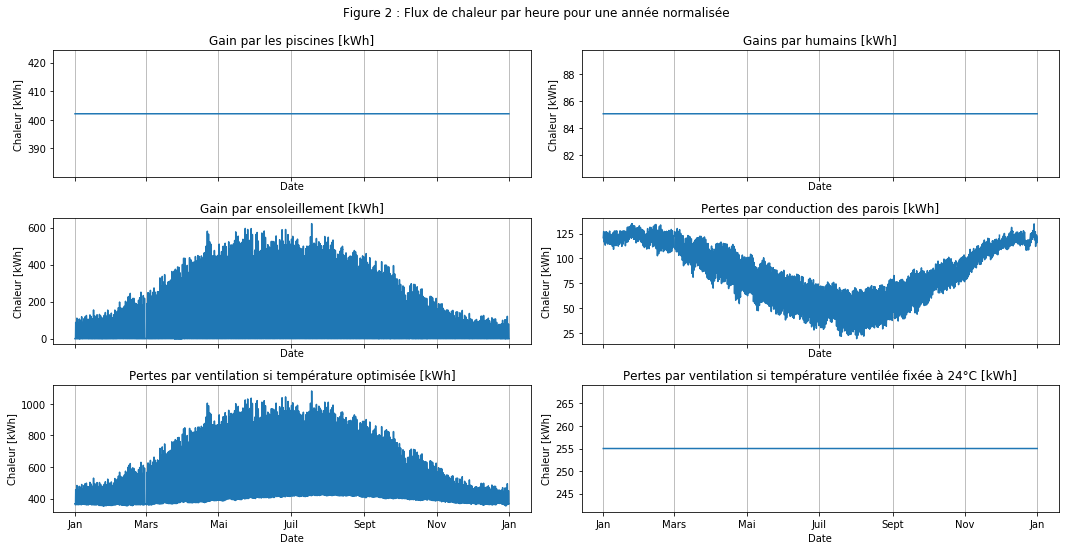

BILAN GLOBAL pour l hypothèse ventilation à température constante:
Vérifions que le flux total est toujours nul


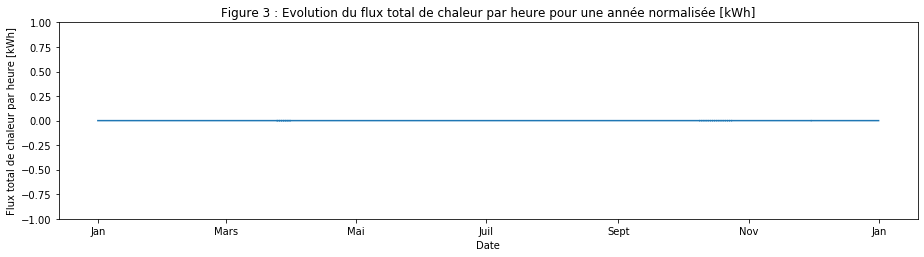

In [29]:
#%% FLUX DE CHALEUR : RéSULTATS ###################################################################################

#%% Transformation en kWh:

P_calJ = P_caldf*3600*(1/3600000)              #Gain par piscine [kWh par heure]:
Q_condtotJ = Q_condtot*3600*(1/3600000)        #Pertes conduction [kWh par heure]:
Q_ensJ = Q_ens*3600*(1/3600000)                #Gain ensoleillement [kWh par heure]:
Q_venJ = Q_ven_kWh                             #Pertes ventilation [kWh par heure]:
Q_ven_24J = Q_ven_24*3600*(1/3600000)          #Pertes ventilation [kWh par heure]:
P_humJ = (P_humM/24)*cst                       #Gain par humains [kWh par heure]:

#%% EVOLUTION AU COURS D'UNE ANNEE NORMALISEE :

#%% Flux de chaleur - graphique :
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(15,8))
plt.suptitle('Figure 2 : Flux de chaleur par heure pour une année normalisée')

axs[0,0].plot(P_calJ)
axs[0,0].set_title('Gain par les piscines [kWh]')

axs[0,1].plot(P_humJ)
axs[0,1].set_title('Gains par humains [kWh]')

axs[1,0].plot(Q_ensJ)
axs[1,0].set_title('Gain par ensoleillement [kWh]')

axs[1,1].plot(Q_condtotJ)
axs[1,1].set_title('Pertes par conduction des parois [kWh]')

axs[2,0].plot(Q_venJ)
axs[2,0].set_title('Pertes par ventilation si température optimisée [kWh]')

axs[2,1].plot(Q_ven_24J)
axs[2,1].set_title('Pertes par ventilation si température ventilée fixée à 24°C [kWh]')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Chaleur [kWh]')
#for ax in axs.flat:
    #ax.label_outer()
for ax in axs.flat:
    ax.grid(axis = 'x')

plt.sca(axs[2, 1])
plt.xticks(['2020-01-01','2020-03-01','2020-05-01','2020-07-01','2020-09-01','2020-11-01','2021-01-01'],['Jan','Mars','Mai','Juil','Sept','Nov','Jan'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#%% EVOLUTION DU FLUX TOTAL

Flux_tot = P_calJ+Q_ensJ+P_humJ-Q_condtotJ-Q_venJ
print('BILAN GLOBAL pour l hypothèse ventilation à température constante:')
print('Vérifions que le flux total est toujours nul')
#Flux_tot_min = np.min(Flux_tot)
#print('Sa valeur minimum est de ', Flux_tot_min, 'kWh. Il n y a donc pas de pertes.')


plt.plot(Flux_tot)
plt.title('Figure 3 : Evolution du flux total de chaleur par heure pour une année normalisée [kWh]')
plt.xlabel('Date')
plt.xticks(['2020-01-01','2020-03-01','2020-05-01','2020-07-01','2020-09-01','2020-11-01','2021-01-01'],['Jan','Mars','Mai','Juil','Sept','Nov','Jan'])
plt.ylabel('Flux total de chaleur par heure [kWh]')
plt.ylim([-1,1])
plt.tight_layout(rect=[0, 0.03, 2.5, 0.95])
plt.show()

De plus, nous pouvons calculer les moyennes journalières de chaque flux sur l'année normalisée. Comme le montre le tableau ci dessous, le flux de chaleur de l'eau des piscines à l'air intérieur est le flux entrant le plus élevé. Nous remarquons également que les pertes par conduction sont assez faibles et compensées en moyenne entièrement par le gain en ensoleillement. Néanmoins, ces deux flux varieront au cours de l'année : l'ensoleillement prendra le pas sur les pertes par conduction en été et inversément en hiver. Pour les pertes par ventilation, elles dépendent donc des autres flux et permettent d'avoir un bilan global nul. En été, pour avoir un bilan global nul, il faudrait que cette température ventilée soit de 17°C et en hiver 21°C. Sur l'année, il faudrait donc pulser un air à température de 19°C pour avoir un flux nul, bien que ces températures risqueraient de gêner les visiteurs.


|$\qquad $ |Gains piscines   :  $\qquad $ | Pertes conduction :  $\qquad $ | Gains ensoleillement : $\qquad $  | Pertes ventilation :$\qquad $ | Gains humains :  $\qquad $ | Bilan :  $\qquad $ |
|:----------------------|:----------------------:|:---------------------:|:-----------------------:|:---------------------:| :---------------------:|:---------------------:|
|Sur l'année|9651 kWh  $\qquad $| - 2101 kWh $\qquad $| 2530 kWh $\qquad $| - 12125 kWh $\qquad $ |2042 kWh $\qquad $|0 kWh $\qquad $|
|Eté| "  $\qquad $| - 1302 kWh $\qquad $| 3875 kWh $\qquad $| - 14265 $\qquad $ | " $\qquad $|0 kWh $\qquad $|
|Hiver| "  $\qquad $| - 2870 kWh $\qquad $| 758 kWh $\qquad $| - 9580 $\qquad $ | " $\qquad $|0 kWh $\qquad $|

$\qquad \qquad \qquad \qquad \qquad $*Tableau 2 : Valeurs moyennes journalières des flux de chaleur calculés de 1998 à 2020*   

In [8]:
### FLUX MOYENS ############################################################################################################

### Moyenne par jour :
P_calM = np.mean(P_calJ)*24                                 #Gain par piscine [kWh moyen en 1 jour]:
print('Gains moyens journaliers par les piscines :', P_calM, 'kWh')
Q_condtotM = np.mean(Q_condtotJ)*24                         #Pertes conduction [kWh moyen en 1 jour]:
print('Pertes moyennnes journalières par conduction :', -Q_condtotM, 'kWh')
Q_ensM = np.mean(Q_ensJ)*24                                 #Gain ensoleillement [kWh moyen en 1 jour]:
print('Gains moyens journaliers par ensoleillement :', Q_ensM, 'kWh')
Q_venM = np.mean(Q_venJ)*24                                 #Pertes ventilation [kWh moyen en 1 jour]:
print('Pertes moyennnes journalières par ventilation :', -Q_venM, 'kWh')
P_humM = P_humtot/3600000                                   #Gain par humains [kWh moyen en 1 jour]:
print('Gains moyens journaliers par activité humaine :', P_humM, 'kWh')

### Hiver et été :

# été :

P_calété_moy = np.mean(P_calJ.loc['2020-06-21':'2020-09-22'])*24
Q_condtotété_moy = np.mean(Q_condtotJ.loc['2020-06-21':'2020-09-22'])*24
Q_ensété_moy = np.mean(Q_ensJ.loc['2020-06-21':'2020-09-22'])*24 
Q_venété_moy = np.mean(Q_venJ.loc['2020-06-21':'2020-09-22'])*24
P_humété_moy = np.mean(P_humJ.loc['2020-06-21':'2020-09-22'])*24

print('En ETE, les moyennes deviennent (dans l ordre précédent) :')
print(P_calété_moy)
print(-Q_condtotété_moy)
print(Q_ensété_moy)
print(-Q_venété_moy)
print(P_humété_moy)

# hiver : Remarque : pour eviter tout probleme avec les 29 févriers, les années bissextiles n'ont pas été prises en compte dans la moyenne
P_calhiv_moy = (np.mean(P_calJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(P_calJ.loc['2020-12-21':'2020-12-31'])*24)/2
Q_condtothiv_moy = (np.mean(Q_condtotJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(Q_condtotJ.loc['2020-12-21':'2020-12-31'])*24)/2
Q_enshiv_moy = (np.mean(Q_ensJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(Q_ensJ.loc['2020-12-21':'2020-12-31'])*24)/2
Q_venhiv_moy = (np.mean(Q_venJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(Q_venJ.loc['2020-12-21':'2020-12-31'])*24)/2
P_humhiv_moy = (np.mean(P_humJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(P_humJ.loc['2020-12-21':'2020-12-31'])*24)/2

print('En HIVER, les moyennes deviennent (dans l ordre précédent) :')
print(P_calhiv_moy)
print(-Q_condtothiv_moy)
print(Q_enshiv_moy)
print(-Q_venhiv_moy)
print(P_humhiv_moy)



Gains moyens journaliers par les piscines : 9651.122355376472 kWh
Pertes moyennnes journalières par conduction : -2101.2824336609697 kWh
Gains moyens journaliers par ensoleillement : 2530.2822234543437 kWh
Pertes moyennnes journalières par ventilation : -12125.55489220709 kWh
Gains moyens journaliers par activité humaine : 2041.841850875585 kWh
En ETE, les moyennes deviennent (dans l ordre précédent) :
9651.1223553756
-1302.360127844588
3874.610323774269
-14265.214402180445
2041.8418508756322
En HIVER, les moyennes deviennent (dans l ordre précédent) :
9651.122355375348
-2870.444708290634
757.8383643195225
-9580.357862279634
2041.841850875606


Enfin, si on s'intéresse cette fois aux variations périodiques journalières, nous pouvons observer un pic très logique du gain du à l'ensoleillement vers le milieu de la journée, ainsi qu'un flux de chaleur maximum par ventilation et par conduction en matinée, suivi d'une grande chute pendant la journée, dûe à la hausse de température. 

### 3.2 Flux d'eau :

Dans notre modèle simplifié, nous considèrons que les flux d'eau ne dépendent pas des facteurs extérieurs. Ils ont donc une valeur constante.
+ Le flux d'eau évaporée de la piscine est de 659 $kg/h$. Il contribue au débit d'eau gagné par l'atmosphère intérieure.
+ Le flux d'eau sortant par ventilation est de 2847 $kg/h$. C'est le débit d'eau perdu par l'atmosphère intérieure.
+ Le flux d'eau entrant par ventilation nécessaire pour équilibrer le système est de 2188 $kg/h$. Il complète le débit d'eau gagné par l'atmosphère intérieure.


In [9]:
#%% FLUX D'EAU : RESULTATS ########################################################################################################
print('Le flux de vapeur d eau évaporée par les piscines est de',W_evap,'kg/h.')
print('Le flux de vapeur d eau perdue par ventilation est de',- W_vent_out,'kg/h.')

#%% FLUX d'eau 2b : Ventilation : air entrant ####################################################################################

print('Le flux de vapeur d eau gagnée par ventilation est de',W_vent_in,'kg/h.')
print('On doit ajouter de l air à ',np.mean(HR_ventin), '% d humidité pour évacuer les',W_evap, 'kg/h de vapeur des piscines et ainsi garder une humidité constante.')

Le flux de vapeur d eau évaporée par les piscines est de 658.9097999082728 kg/h.
Le flux de vapeur d eau perdue par ventilation est de -2846.9953955565043 kg/h.
Le flux de vapeur d eau gagnée par ventilation est de 2188.0855956482314 kg/h.
On doit ajouter de l air à  46.810033812041304 % d humidité pour évacuer les 658.9097999082728 kg/h de vapeur des piscines et ainsi garder une humidité constante.


### 3.3 Demandes énergétiques

Les demandes énergétiques se répartissent sur trois secteurs : le chauffage de l'eau, la ventilation, et le traitement de l'air (chauffage et déshumidification). Au total, les demandes d'Aqualibi seront en moyenne chaque année de 6853 MWh. Nous pouvons représenter les moyennes annuelles de la répartition des demandes entre ces différents secteurs.

Néanmoins, cette répartition va varier entre l'été et l'hiver, puisque les demandes pour le traitement de l'air seront sensibles au climat, et plus grandes lorsqu'il fait froid (chauffage nécessaire) et humide (déshumidification nécessaire) à l'extérieur.

BILAN ANNUEL :
La demande énergétique moyenne d Aqualibi sur un an est de 6852.743088045874 MWh
ce qui revient à 18774.638597385958 kWh par jour.


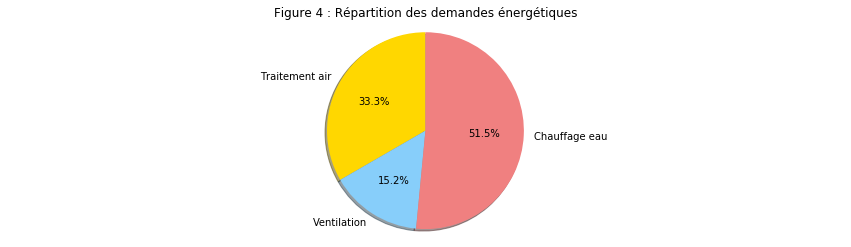

BILAN ETE VS HIVER :
La demande énergétique moyenne d Aqualibi sur un jour d été est de 19887.50447252936 kWh.
La demande énergétique moyenne d Aqualibi sur un jour d hiver est de 17655.81663196277 MWh.


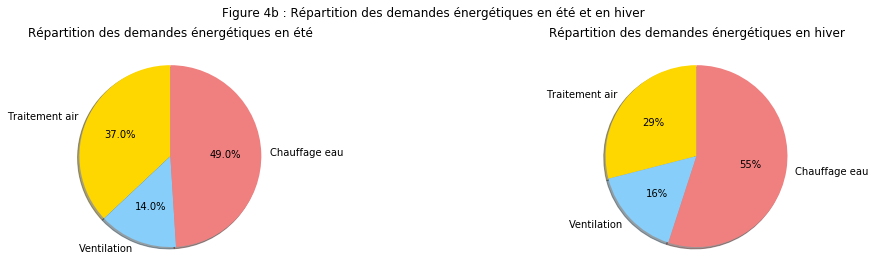

In [9]:
#%% DEMANDES ENERGETIQUES :

#%% Moyennes annuelles : ##############################################################################################

#D_pis_an      # Chauffage de l' eau [MWh] pour un an
#D_vent_an     # Ventilation  [MWh] pour un an      
#D_déshum_an   # Déshumidification [MWh] en un an
#D_tot_an      # DEPENSE TOTALE [MWh] en un an
print('BILAN ANNUEL :')
print('La demande énergétique moyenne d Aqualibi sur un an est de', D_tot_an, 'MWh')
print('ce qui revient à',D_tot_an*1000/365, 'kWh par jour.')


#%% Demande énergétique - Pie plot :
Prop_D_pis_an = round((D_pis_an/D_tot_an)*100)
Prop_D_vent_an = round((D_vent_an/D_tot_an)*100)
Prop_D_déshum_an = round((D_déshum_an/D_tot_an)*100)

plt.figure(figsize=(15,4))
labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
sizes = [Prop_D_déshum_an, Prop_D_vent_an, Prop_D_pis_an]
colors = ['gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Figure 4 : Répartition des demandes énergétiques')
plt.show()


### Moyennes été : #################################################################################################

D_pis_an_été = D_pis_jour                                                  # Chauffage de l' eau [kWh] pour un jour
D_vent_an_été = D_vent_jour                                                # Ventilation  [kWh] pour un jour 
D_déshumJ = D_déshum/1000                                                  # Déshumidification [kWh] chaque heure  
D_déshum_an_été = np.mean(D_déshumJ.loc['2020-06-21':'2020-09-22'])*24     # Déshumidification [kWh] en un jour
D_tot_an_été = D_pis_an_été + D_vent_an_été + D_déshum_an_été              # DEPENSE TOTALE [MWh] en un an
print('BILAN ETE VS HIVER :')
print('La demande énergétique moyenne d Aqualibi sur un jour d été est de', D_tot_an_été, 'kWh.')

#Demande énergétique - Pie plot :
Prop_D_pis_an_été = round((D_pis_an_été/D_tot_an_été)*100)
Prop_D_vent_an_été = round((D_vent_an_été/D_tot_an_été)*100)
Prop_D_déshum_an_été = round((D_déshum_an_été/D_tot_an_été)*100)

### Moyennes hiver : #################################################################################################

D_pis_an_hiv = D_pis_jour                                                  # Chauffage de l' eau [kWh] pour un jour
D_vent_an_hiv = D_vent_jour                                                # Ventilation  [kWh] pour un jour 
D_déshum_an_hiv = (np.mean(D_déshumJ.loc['2020-01-01':'2020-03-22'])*24 + np.mean(D_déshumJ.loc['2020-12-21':'2020-12-31'])*24)/2
                                                                           # Déshumidification [kWh] en un jour
D_tot_an_hiv = D_pis_an_hiv + D_vent_an_hiv + D_déshum_an_hiv              # DEPENSE TOTALE [MWh] en un an
print('La demande énergétique moyenne d Aqualibi sur un jour d hiver est de', D_tot_an_hiv, 'MWh.')

#Demande énergétique - Pie plot :
Prop_D_pis_an_hiv = round((D_pis_an_hiv/D_tot_an_hiv)*100)
Prop_D_vent_an_hiv = round((D_vent_an_hiv/D_tot_an_hiv)*100)
Prop_D_déshum_an_hiv = round((D_déshum_an_hiv/D_tot_an_hiv)*100)


### PIE PLOT ETE VS HIVER #################################################################################################

fig, axs = plt.subplots(1, 2, figsize=(16,4))
plt.suptitle('Figure 4b : Répartition des demandes énergétiques en été et en hiver')

labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
colors = ['gold', 'lightskyblue', 'lightcoral']
sizes_été = [Prop_D_déshum_an_été, Prop_D_vent_an_été, Prop_D_pis_an_été]
sizes_hiv = [Prop_D_déshum_an_hiv, Prop_D_vent_an_hiv, Prop_D_pis_an_hiv]

axs[0].pie(sizes_été, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title('Répartition des demandes énergétiques en été')

axs[1].pie(sizes_hiv, labels=labels, colors=colors, autopct='%.0f%%', shadow=True, startangle=90)
axs[1].set_title('Répartition des demandes énergétiques en hiver')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 3.4 Couts énergétiques

##### A) Gestion actuelle :
Les dépenses énergétiques vont être liées à la consommation de gaz par la chaudière et à la consommation d'électricité par les pompes à chaleur et le circuit de ventilation. 

+ **Le débit de gaz** nécessaire pour compenser 2/3 des pertes calorifiques de la piscine est de 27,4 $m^3/h$. Remarquons que si nous utilisons une chaudière à condensation (meilleur rendement), ce débit descend à 23,7 $m^3/h$, soit une économie de 3,7 $m^3/h$.
+ **La puissance électrique** requise par le système va dépendre entre autre de la ventilation et donc de la température extérieure. Elle variera donc au cours de l'année et de la journée (*Figure 6*). Sur une moyenne quotidienne, la puissance électrique requise est de 413 kW (soit 9920 kWh par jour), dont les porportions utilisées sont représentées ci-dessous (*Figure 5*). Ces proportions vont elles aussi varier de l'été à l'hiver comme le montre la *Figure 5b*.

**Remarque :** La puissance électrique demandée est plus importante en été qu'en hiver. Ceci peut paraître étonnant mais témoigne du coût très important qu'engendre la déshumidification, pôle le plus consommant de notre système. La déshumidification sera en effet plus coûteuse en été puisque l'air extérieur sera en moyenne plus humide qu'en hiver.

DEBIT DE GAZ :
Débit de gaz nécessaire : 27.432130725872575 m^3/h (chaudière classique)
Débit de gaz nécessaire : 23.739343897389727 m^3/h (chaudière à condensation)
------------------
PUISSANCE ELECTRIQUE :
Puissance moyenne totale :  413.32224318038647 kW
ce qui équivaut à une dépense électrique en un jour de  9919.733836329275 kWh, (= 3620.702850260185 MWh par an)
cette moyenne devient 8800.91187090606 kWh en hiver et 11032.599711472627 kWh en été.


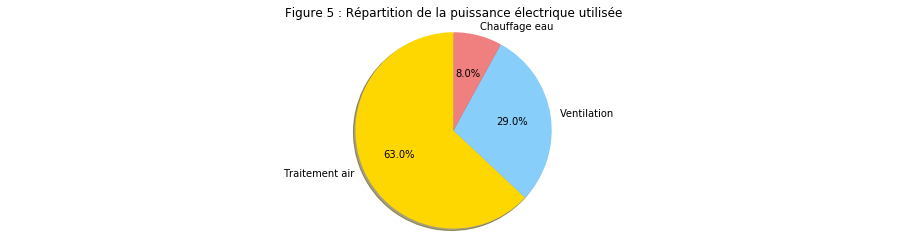

PUISSANCE ELECTRIQUE ETE VS HIVER :
Energie électrique moyenne totale demandée par jour en été : 11032.59971147259 kWh
Energie électrique moyenne totale demandée par jour en hiver : 8800.911870906006 kWh


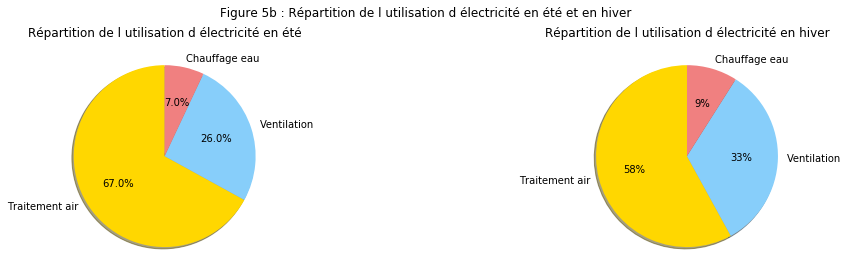

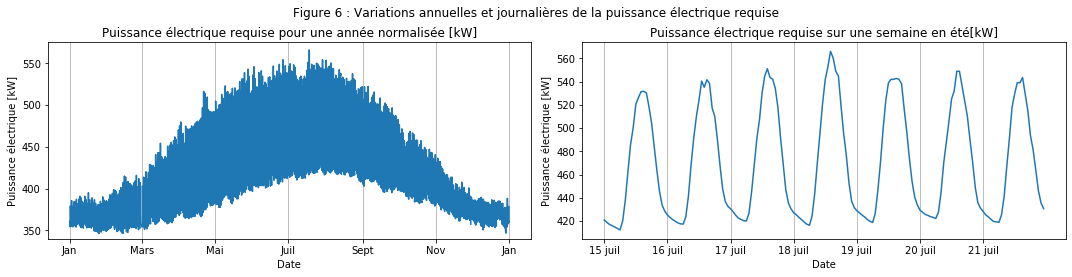

In [10]:
#%% COUTS A: RESULTATS :#############################################################################################################

### Débit de combustible [m^3/h]: ############################################################################################################
print('DEBIT DE GAZ :')
Mch = Mc*3600            #Chaudière classique
print('Débit de gaz nécessaire :',Mch,'m^3/h (chaudière classique)')
Mcoptih = Mcopti*3600    #Chaudière à condensation
print('Débit de gaz nécessaire :',Mcoptih,'m^3/h (chaudière à condensation)')
print('------------------')

### Puissance électrique [kW]: ############################################################################################################
print('PUISSANCE ELECTRIQUE :')

Pe_tot = (Pe_pacdf + Pe_ventdf + Pe_déshum)/1000

### FLUX MOYENS ANNUELS ################################################################################################################

Pe_totM = np.mean(Pe_tot)
print('Puissance moyenne totale : ', Pe_totM, 'kW')
Pe_totMj = Pe_totM * 24                                                      #Energie en un jour
Pe_totMa = Pe_totMj * 365/1000
print('ce qui équivaut à une dépense électrique en un jour de ', Pe_totMj, 'kWh, (=',Pe_totMa,'MWh par an)')
Pe_totMj_été = np.mean(Pe_tot.loc['2020-06-21':'2020-09-22'])*24
Pe_totMj_hiv = ((np.mean(Pe_tot.loc['2020-01-01':'2020-03-22'])+np.mean(Pe_tot.loc['2020-12-21':'2020-12-31']))/2)*24
print('cette moyenne devient',Pe_totMj_hiv,'kWh en hiver et',Pe_totMj_été,'kWh en été.')

## Puissance électrique - Pie plot :
Pe_pacM = np.mean(Pe_pacdf)/1000                       # kW
Prop_pac = round((Pe_pacM/Pe_totM)*100)
Pe_ventM = np.mean(Pe_ventdf)/1000                     # kW
Prop_vent = round((Pe_ventM/Pe_totM)*100)
Pe_déshumM = np.mean(Pe_déshum)/1000                   # kW
Prop_déshum = round((Pe_déshumM/Pe_totM)*100)

# PIE PLOT :
plt.figure(figsize=(16,4))
labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
sizes = [Prop_déshum, Prop_vent, Prop_pac]
colors = ['gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Figure 5 : Répartition de la puissance électrique utilisée')
plt.show()

### ETE VS HIVER :############################################################################################################
print('PUISSANCE ELECTRIQUE ETE VS HIVER :')
### Moyennes été : #########

Pe_pacM_été = Pe_pacM                                                    # Chauffage de l' eau [kW]
Pe_ventM_été = Pe_ventM                                                  # Ventilation  [kW] 
Pe_déshumM_été = np.mean(Pe_déshum.loc['2020-06-21':'2020-09-22'])/1000  # Déshumidification [kW]
Pe_totW_été = Pe_pacM_été + Pe_ventM_été + Pe_déshumM_été                # DEPENSE TOTALE [kW] 
Pe_totM_été = Pe_totW_été*1000*3600*24/3600000                           # DEPENSE TOTALE [kWh] en un jour
print('Energie électrique moyenne totale demandée par jour en été :',Pe_totM_été,'kWh')

#Demande énergétique - Pie plot :
Prop_Pe_pac_été = round((Pe_pacM_été/Pe_totW_été)*100)
Prop_Pe_vent_été = round((Pe_ventM_été/Pe_totW_été)*100)
Prop_Pe_déshum_été = round((Pe_déshumM_été/Pe_totW_été)*100)

### Moyennes hiver : #########

Pe_pacM_hiv = Pe_pacM                                                    # Chauffage de l' eau [kW] 
Pe_ventM_hiv = Pe_ventM                                                  # Ventilation  [kW] 
Pe_déshumM_hiv = (np.mean(Pe_déshum.loc['2020-01-01':'2020-03-22'])+np.mean(Pe_déshum.loc['2020-12-21':'2020-12-31']))/(2*1000)  # Déshumidification [kW]
Pe_totW_hiv = Pe_pacM_hiv + Pe_ventM_hiv + Pe_déshumM_hiv                # DEPENSE TOTALE [kW] 
Pe_totM_hiv = Pe_totW_hiv*1000*3600*24/3600000                           # DEPENSE TOTALE [kWh] en un jour
print('Energie électrique moyenne totale demandée par jour en hiver :',Pe_totM_hiv,'kWh')

#Demande énergétique - Pie plot :
Prop_Pe_pac_hiv = round((Pe_pacM_hiv/Pe_totW_hiv)*100)
Prop_Pe_vent_hiv = round((Pe_ventM_hiv/Pe_totW_hiv)*100)
Prop_Pe_déshum_hiv = round((Pe_déshumM_hiv/Pe_totW_hiv)*100)

### PIE PLOT ############

fig, axs = plt.subplots(1, 2, figsize=(16,4))
plt.suptitle('Figure 5b : Répartition de l utilisation d électricité en été et en hiver')

labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
colors = ['gold', 'lightskyblue', 'lightcoral']
sizes_Pété = [Prop_Pe_déshum_été, Prop_Pe_vent_été, Prop_Pe_pac_été]
sizes_Phiv = [Prop_Pe_déshum_hiv, Prop_Pe_vent_hiv, Prop_Pe_pac_hiv]

axs[0].pie(sizes_Pété, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title('Répartition de l utilisation d électricité en été')

axs[1].pie(sizes_Phiv, labels=labels, colors=colors, autopct='%.0f%%', shadow=True, startangle=90)
axs[1].set_title('Répartition de l utilisation d électricité en hiver')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### GRAPHES VARIATIONS Pe_tot : ############################################################################################################
Pe_tot_semaineété = Pe_tot.loc['2020-07-15':'2020-07-21']

fig, axs = plt.subplots(1, 2, sharex= 'col', figsize=(15,4))
plt.suptitle('Figure 6 : Variations annuelles et journalières de la puissance électrique requise')

axs[0].plot(Pe_tot)
axs[0].set_title('Puissance électrique requise pour une année normalisée [kW]')

axs[1].plot(Pe_tot_semaineété)
axs[1].set_title('Puissance électrique requise sur une semaine en été[kW]')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Puissance électrique [kW]')
for ax in axs.flat:
    ax.grid(axis = 'x')
#for ax in axs.flat:
#    ax.label_outer()
plt.sca(axs[0])
plt.xticks(['2020-01-01','2020-03-01','2020-05-01','2020-07-01','2020-09-01','2020-11-01','2021-01-01'],['Jan','Mars','Mai','Juil','Sept','Nov','Jan'])
plt.ylim([340,575])
plt.sca(axs[1])
plt.xticks(['2020-07-15','2020-07-16','2020-07-17','2020-07-18','2020-07-19','2020-07-20','2020-07-21'],['15 juil','16 juil','17 juil','18 juil','19 juil','20 juil','21 juil'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



##### B) Gestion verte :

Une solution possible de gestion d'énergie pour Aqualibi serait l'utilisation de 100% d'électricité 'verte'. En comptant l'utilisation de pompes à chaleur pour le chauffage, la quantité totale d'énergie électrique nécessaire par jour serait alors de 11,54 MWh, soit 4,211 GWh par an. A nouveau, cette moyenne ainsi que les proportions d'électricité utilisée dans les différents pôles vont varier de l'été à l'hiver. Notre système coûte également plus en été qu'en hiver. En comparaison avec la gestion d'énergie précédente, nous voyons que le chauffage de l'eau prend plus de place puisqu'il est à présent assuré entièrement par les pompes à chaleur approvisionnées en électricité. 

PUISSANCE ELECTRIQUE EN GESTION VERTE :
Energie électrique moyenne totale demandée par jour : 11536.296830854642 kWh
ce qui revient à 4210.748343261944 MWh par an


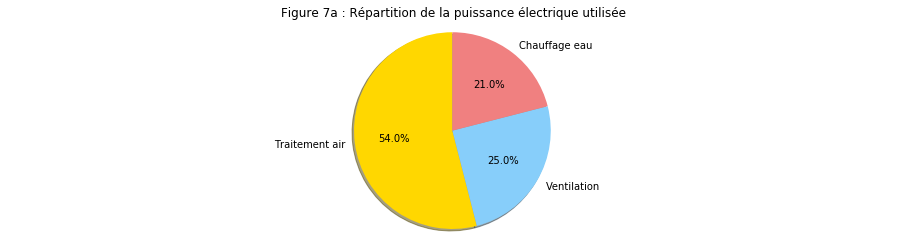

PUISSANCE ELECTRIQUE ETE VS HIVER :
Energie électrique moyenne totale demandée par jour en été : 12649.162705998313 kWh
Energie électrique moyenne totale demandée par jour en hiver : 10417.47486543173 kWh


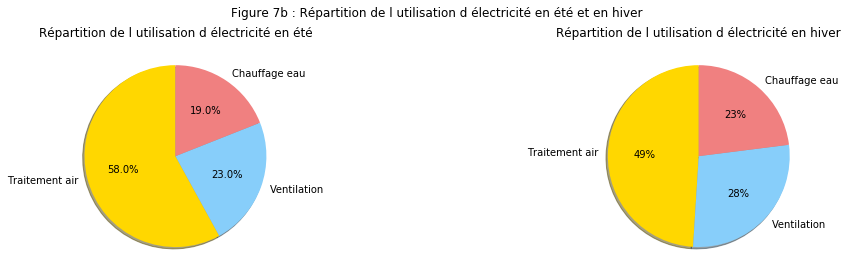

In [11]:
#%% COUTS B : RESULTATS :#############################################################################################################
print('PUISSANCE ELECTRIQUE EN GESTION VERTE :')

#Puissance électrique totale sans chaudière :
Pe_totB = Pe_pacBdf + Pe_ventdf + Pe_déshum            #[W = J/s]
Pe_totBJ = Pe_totB*3600*(1/3600000)                    #[kWh par heure]
Pe_totBW = np.mean(Pe_totB)/1000                       #[kW moyen]
Pe_totBM = np.mean(Pe_totBJ)*24                        #[kWh par jour moyen]
Pe_totBMA = (Pe_totBM*365)/1000                        #[MWh par an moyen]
print('Energie électrique moyenne totale demandée par jour :',Pe_totBM,'kWh')
print('ce qui revient à',Pe_totBMA,'MWh par an')

#%% POSTER PLOT 1
#with plt.style.context('seaborn'):
#        plt.plot(Pe_totBJ*24/1000)
#        plt.xticks(['2020-01-01','2020-03-01','2020-05-01','2020-07-01','2020-09-01','2020-11-01','2021-01-01'],['Jan','Mars','Mai','Juil','Sept','Nov','Jan'])
#        plt.ylim([9,11.6])
#        plt.tight_layout(rect=[0, 0.03, 2.5, 0.95])
#        plt.show()


#%% FLUX MOYENS ############################################################################################################

Pe_pacM_B = np.mean(Pe_pacBdf)/1000                                       #kW
Prop_pac_B = round((Pe_pacM_B/Pe_totBW)*100)
Pe_ventM_B = np.mean(Pe_ventdf)/1000                                      #kW
Prop_vent_B = round((Pe_ventM_B/Pe_totBW)*100)

Pe_déshumM_B = np.mean(Pe_déshum)/1000                                    #kW
Prop_déshum_B = round((Pe_déshumM_B/Pe_totBW)*100)

### POSTER PLOT 2
#labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
#sizes = [Prop_déshum_B, Prop_vent_B, Prop_pac_B]
#colors = ['gold', 'lightskyblue', 'lightcoral']

#with plt.style.context('fivethirtyeight'):
#        plt.figure(figsize=(16,4))
#        plt.pie(sizes, colors=colors, 
#                autopct='%1.1f%%', shadow=False, startangle=90)
#        plt.axis('equal')
#        plt.show()


### Puissance électrique - Pie plot :

plt.figure(figsize=(16,4))
labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
sizes = [Prop_déshum_B, Prop_vent_B, Prop_pac_B]
colors = ['gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Figure 7a : Répartition de la puissance électrique utilisée')
plt.show()


### MOYENNES ETE : #####################################################################################################################
print('PUISSANCE ELECTRIQUE ETE VS HIVER :')

Pe_pacM_B_été = Pe_pacM_B                                                  # Chauffage de l' eau [kW]
Pe_ventM_B_été = Pe_ventM_B                                                # Ventilation  [kW] 
Pe_déshumM_B_été = np.mean(Pe_déshum.loc['2020-06-21':'2020-09-22'])/1000  # Déshumidification [kW]
Pe_totBW_été = Pe_pacM_B_été + Pe_ventM_B_été + Pe_déshumM_B_été           # DEPENSE TOTALE [kW] 
Pe_totBM_été = Pe_totBW_été*1000*3600*24/3600000                           # DEPENSE TOTALE [kWh] en un jour
print('Energie électrique moyenne totale demandée par jour en été :',Pe_totBM_été,'kWh')

#Demande énergétique - Pie plot :
Prop_P_pac_été = round((Pe_pacM_B_été/Pe_totBW_été)*100)
Prop_P_vent_été = round((Pe_ventM_B_été/Pe_totBW_été)*100)
Prop_P_déshum_été = round((Pe_déshumM_B_été/Pe_totBW_été)*100)

### MOYENNES HIVER : #####################################################################################################################

Pe_pacM_B_hiv = Pe_pacM_B                                                  # Chauffage de l' eau [kW] 
Pe_ventM_B_hiv = Pe_ventM_B                                                # Ventilation  [kW] 
Pe_déshumM_B_hiv = (np.mean(Pe_déshum.loc['2020-01-01':'2020-03-22'])+np.mean(Pe_déshum.loc['2020-12-21':'2020-12-31']))/(2*1000)  # Déshumidification [kW]
Pe_totBW_hiv = Pe_pacM_B_hiv + Pe_ventM_B_hiv + Pe_déshumM_B_hiv           # DEPENSE TOTALE [kW] 
Pe_totBM_hiv = Pe_totBW_hiv*1000*3600*24/3600000                           # DEPENSE TOTALE [kWh] en un jour
print('Energie électrique moyenne totale demandée par jour en hiver :',Pe_totBM_hiv,'kWh')

#Demande énergétique - Pie plot :
Prop_P_pac_hiv = round((Pe_pacM_B_hiv/Pe_totBW_hiv)*100)
Prop_P_vent_hiv = round((Pe_ventM_B_hiv/Pe_totBW_hiv)*100)
Prop_P_déshum_hiv = round((Pe_déshumM_B_hiv/Pe_totBW_hiv)*100)

### PIE PLOT ############################################################################################

fig, axs = plt.subplots(1, 2, figsize=(16,4))
plt.suptitle('Figure 7b : Répartition de l utilisation d électricité en été et en hiver')

labels = 'Traitement air', 'Ventilation', 'Chauffage eau'
colors = ['gold', 'lightskyblue', 'lightcoral']
sizes_Pété = [Prop_P_déshum_été, Prop_P_vent_été, Prop_P_pac_été]
sizes_Phiv = [Prop_P_déshum_hiv, Prop_P_vent_hiv, Prop_P_pac_hiv]

axs[0].pie(sizes_Pété, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title('Répartition de l utilisation d électricité en été')

axs[1].pie(sizes_Phiv, labels=labels, colors=colors, autopct='%.0f%%', shadow=True, startangle=90)
axs[1].set_title('Répartition de l utilisation d électricité en hiver')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 4. Solutions :

### 4.1 Panneaux photovoltaïques :

1. **Première approche : dimmensionnement d'une solution :**

Pour fournir cette électricité de façon durable et respectueuse de l'environnement, la solution des panneaux photovoltaïques semble la plus adaptée à Aqualibi. En effet, bien qu'Aqualibi ne puisse pas recouvrir son toit vitré de panneaux par soucis de luminosité intérieure,le parc possède un parking d'une superficie totale de 64000 $m^2$. L'installation de panneaux photovoltaïques au-dessus des places de parking permettrait donc de subvenir aux besoins énergétiques d'Aqualibi.

Nous pouvons calculer le nombre de panneaux ainsi que la surface au sol correspondante nécessaire à cet objectif.

La surface totale nécessaire des panneaux peut être calculée comme suit :
$$
S_{pan} = \frac {P_{max} \ nécessaire}{ \eta_{pan}\ .\ R_s\ .\ cos(\alpha) }
$$
avec
+ $S_{pan} :$ Surface totale nécessaire recouverte par des panneaux photovoltaïques $[m^2]$
+ $P_{max} nécessaire :$ Energie électrique maximale demandée un une heure $[MJ]$
+ $\eta_{pan} :$ Rendement des panneaux photovoltaïques pour convertir énergie lumineuse en énergie électrique $[-]$
+ $R_s :$ Ensoleillement $[MJ/m^2]$
+ $cos(\alpha) = 1 :$ Influence de l'angle d'incidence - On considère un angle parfait de 90° pour simplifier $[-]$

Si nous choisissons les panneaux SUNPOWER MAXEON 3-400WC, dans les plus efficaces au monde, le rendement est de 22.6% et leurs dimensions sont de 1.69x1.046m. Dès lors, nous pouvons calculer le nombre de panneaux nécessaire.

**Remarque :** Les résultats de cette première section sont des valeurs moyennes estimées et ne sont donc que d'ordre indicatif,comme première approche. Pour un bilan énergétique plus précis, le lecteur est invité à lire le point 2. Bilan énergie de la solution proposée.

In [17]:
#%% Panneaux photovoltaïques pour Aqualibi 
# https://news.energysage.com/what-are-the-most-efficient-solar-panels-on-the-market/
# https://www.planetsoarshop.com/fr/produits/Sunpower-Maxeon-3-400Wc/fiche-technique


### MOYENNE ANNEE ##############################################################################################################
print('MOYENNES ANNEE :')
# Quantité consommée du bâtiment
Pe_heure = Pe_totBJ*0.001                  #MWh/heure
Pe_heure_joule = Pe_heure*3600             #MJ/heure 
Angle = 0
Influence_angle_incident = m.cos(Angle)

# Production (on considère un angle droit par rapport aux rayons incidents)
Rendement_panneaux = 0.226 #(modèle: Panneau solaire SUNPOWER MAXEON 3-400WC)
data_meteo_ens_heure = np.mean(ens_norm)
Pe_heure_joule_max = Pe_heure_joule.max()
    #Ind_max = Pe_heure_joule.idxmax()
    #ensoleillement_H = ensoleillement.loc[Ind_max]
    #print(ensoleillement_H)
Surf_panneaux = Pe_heure_joule_max*10**(6)/(Rendement_panneaux*data_meteo_ens_heure*(60*60)*Influence_angle_incident)  #m2

#Nombre de panneaux (modèle Panneau solaire SUNPOWER MAXEON 3-400WC)
L = 1.69 #longueur (m)
l = 1.046 #largeur (m)
Aire_panneau = L*l
Nombre_panneaux = round(Surf_panneaux/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Nombre_palettes = round(Nombre_panneaux/26)
Prix = (Nombre_palettes*7856.08)+((Nombre_panneaux-(Nombre_palettes*26))*313.5)     #Palettes de 26 panneaux (7856€) + panneaux supplémentaires (313.5€)
Pourcentage_parking = (Surf_panneaux/55000)*100

print('Il faut installer', Nombre_panneaux, 'panneaux photovoltaïques sur le parking')
print('ce qui revient à une surface totale de', Surf_panneaux, 'm^2, soit ', Pourcentage_parking,'% de la surface du parking.')
print('et cela coûtera', Prix, '€ pour la totalité des panneaux demandés par Aqualibi.')

# Surface totale parking = 64 000 m^2 --> Environ 85% (55000 m^2) recouvrable si on laisse les allées ouvertes (lumière)
# SUNPOWER MAXEON 3-400WC : 1.69x1.046, Pmax = 400W, Rendement = 22.6%


#### ETE ##############################################################################################################
Pe_heure_été = (Pe_totBJ.loc['2020-06-21':'2020-09-22'])*0.001               #MWh/heure
Pe_heure_joule_été = Pe_heure_été*3600                                       #MJ/heure 

# Production (on considère un angle droit par rapport aux rayons incidents)
data_meteo_ens_heure_été = np.mean(ens_norm.loc['2020-06-21':'2020-09-22'])
Pe_heure_joule_été_max = Pe_heure_joule_été.max()
Surf_panneaux_été = Pe_heure_joule_été_max*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_été*(60*60)*Influence_angle_incident)  #m2

#Nombre de panneaux (modèle Panneau solaire SUNPOWER MAXEON 3-400WC)
Nombre_panneaux_été = round(Surf_panneaux_été/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Pourcentage_parking_été = (Surf_panneaux_été/55000)*100

print('------------------')
print('MOYENNES ETE :')
print('Aqualibi utilisera en été', Nombre_panneaux_été, 'panneaux photovoltaïques du parking')
print('ce qui revient à une surface totale de', Surf_panneaux_été, 'm^2, soit ', Pourcentage_parking_été,'% de la surface du parking.')

#### HIVER ##########
Pe_heure_hiv1 = (Pe_totBJ.loc['2020-01-01':'2020-03-22'])*0.001               #MWh/heure
Pe_heure_hiv2 = (Pe_totBJ.loc['2020-12-21':'2020-12-31'])*0.001               #MWh/heure
Pe_heure_joule_hiv1 = Pe_heure_hiv1*3600                                       #MJ/heure 
Pe_heure_joule_hiv2 = Pe_heure_hiv2*3600                                       #MJ/heure

# Production (on considère un angle droit par rapport aux rayons incidents)
data_meteo_ens_heure_hiv = (np.sum(ens_norm.loc['2020-01-01':'2020-03-22'])+np.sum(ens_norm.loc['2020-12-21':'2020-12-31']))/(92*24)
Pe_heure_joule_hiv_max1 = Pe_heure_joule_hiv1.max()
Pe_heure_joule_hiv_max2 = Pe_heure_joule_hiv2.max()
if Pe_heure_joule_hiv_max1>Pe_heure_joule_hiv_max2 :
    Pe_heure_joule_hiv_max = Pe_heure_joule_hiv_max1
else :
    Pe_heure_joule_hiv_max = Pe_heure_joule_hiv_max2
Surf_panneaux_hiv = Pe_heure_joule_hiv_max*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_hiv*(60*60)*Influence_angle_incident)  #m2

#Nombre de panneaux (modèle Panneau solaire SUNPOWER MAXEON 3-400WC)
Nombre_panneaux_hiv = round(Surf_panneaux_hiv/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Pourcentage_parking_hiv = (Surf_panneaux_hiv/55000)*100

print('------------------')
print('MOYENNES HIVER :')
print('Aqualibi utilisera en hiver', Nombre_panneaux_hiv, 'panneaux photovoltaïques du parking')
print('ce qui revient à une surface totale de', Surf_panneaux_hiv, 'm^2, soit ', Pourcentage_parking_hiv,'% de la surface du parking.')


MOYENNES ANNEE :
Il faut installer 13956 panneaux photovoltaïques sur le parking
ce qui revient à une surface totale de 24669.144002051366 m^2, soit  44.85298909463884 % de la surface du parking.
et cela coûtera 4216833.96 € pour la totalité des panneaux demandés par Aqualibi.
------------------
MOYENNES ETE :
Aqualibi utilisera en été 9114 panneaux photovoltaïques du parking
ce qui revient à une surface totale de 16109.980441961881 m^2, soit  29.290873530839782 % de la surface du parking.
------------------
MOYENNES HIVER :
Aqualibi utilisera en hiver 28531.0 panneaux photovoltaïques du parking
ce qui revient à une surface totale de 50433.614931461394 m^2, soit  91.69748169356617 % de la surface du parking.


Or si nous décidons de construire des panneaux sur l'entièreté du parking, à l'exception des allées pour laisser passer de la lumière, nous avons une surface totale recouvrable de 55 000 $m^2$. Nous pourrions utiliser le reste de la place disponible pour alimenter le parc Walibi associé à Aqualibi.

+ Surface totale recouvrable parking = 55 000 $m^2$   
+ Surface moyenne panneaux aqualibi = 25 000 $m^2$
+ Surface moyenne panneaux pour walibi = 30 000 $m^2$

Le parc **Walibi** consomme en moyenne selon Engie 7.000.000 kWh par an (2019) avec une puissance max demandée : 2400kW. Il est ouvert d'avril à octobre.

Nous pouvons alors calculer le pourcentage moyen de la consommation de Walibi que les panneaux solaires restant pourraient supporter. Pendant la fermeture du parc Walibi, l'énergie produite supplémentaire (non utilisée par Aqualibi) sera alors en surplus et disponible aux autres utilisateurs du réseau électrique belge.

In [18]:
#%% Energie supplementaire pour Walibi :
print('WALIBI :')
# Quantité consommée du bâtiment
Surf_tot = 55000
Surf_dispo = Surf_tot - Surf_panneaux

# Production (on considère un angle droit par rapport aux rayons incidents)
# Rendement_panneaux = 0.226 #(modèle: Panneau solaire SUNPOWER MAXEON 3-400WC)
Pe_heure_joule_dispo = Surf_dispo *(Rendement_panneaux*data_meteo_ens_heure*(60*60)*Influence_angle_incident)/(10**(6))
Pe_heure_dispo = Pe_heure_joule_dispo / 3600            #MWh/heure
Pe_an_dispo = Pe_heure_dispo * 24 * 365                 #MWh par an
print('Energie fournie par le reste des panneaux solaires sur l année: ', Pe_an_dispo, 'MWh par an')
print('---------------')

### PENDANT L'OUVERTURE DE WALIBI ################################################################################
print('PERIODE D OUVERTURE DE WALIBI :')

Pe_heure_walibiouvert = (Pe_totBJ.loc['2020-04-06':'2020-11-03'])*0.001               #MWh/heure
Pe_heure_joule_walibiouvert = Pe_heure_walibiouvert*3600                                       #MJ/heure 
data_meteo_ens_heure_walibiouvert = np.mean(ens_norm.loc['2020-04-06':'2020-11-03'])
Pe_heure_joule_walibiouvert_max = Pe_heure_joule_walibiouvert.max()
Surf_panneaux_walibiouvert = Pe_heure_joule_walibiouvert_max*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_walibiouvert*(60*60)*Influence_angle_incident)  #m2
Nombre_panneaux_walibiouvert = round(Surf_panneaux_walibiouvert/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Pourcentage_parking_walibiouvert = (Surf_panneaux_walibiouvert/55000)*100
print('Aqualibi utilisera pendant la période d ouverture de Walibi', Nombre_panneaux_walibiouvert, 'panneaux photovoltaïques du parking')
print('ce qui revient à une surface totale de', Surf_panneaux_walibiouvert, 'm^2, soit ', Pourcentage_parking_walibiouvert,'% de la surface du parking.')

# Pour Walibi :
Surf_dispo_walibiouvert = Surf_tot - Surf_panneaux_walibiouvert
Pe_heure_joule_dispo_walibiouvert = Surf_dispo_walibiouvert *(Rendement_panneaux*data_meteo_ens_heure_walibiouvert*(60*60)*Influence_angle_incident)/(10**(6))
Pe_heure_dispo_walibiouvert = Pe_heure_joule_dispo_walibiouvert / 3600            #MWh/heure
Pe_walibiouvert_dispo = Pe_heure_dispo_walibiouvert * 24 *1000                    #kWh par jour
print('Energie fournie par le reste des panneaux solaires pour Walibi pendant son ouverture : ', Pe_walibiouvert_dispo/1000, 'MWh par jour')
Pourcentage_Walibi_walibiouvert = round((Pe_walibiouvert_dispo/(7000000/146))*100)
print('ce qui correspond à',Pourcentage_Walibi_walibiouvert,'% énergie totale demandée par Walibi pendant son ouverture.')


#### ETE ####
print('EN ETE :')
Surf_dispo_été = Surf_tot - Surf_panneaux_été

# Production (on considère un angle droit par rapport aux rayons incidents)
Pe_heure_joule_dispo_été = Surf_dispo_été *(Rendement_panneaux*data_meteo_ens_heure_été*(60*60)*Influence_angle_incident)/(10**(6))
#print(Pe_heure_joule_dispo)    #en MJ/h
Pe_heure_dispo_été = Pe_heure_joule_dispo_été / 3600            #MWh/heure
Pe_été_dispo = Pe_heure_dispo_été * 24 *1000                    #kWh par jour
print('En été, ce chiffre monte à ', Pe_été_dispo/1000, 'MWh par jour')
Pourcentage_Walibi_été = round((Pe_été_dispo/(7000000/146))*100)
print('soit',Pourcentage_Walibi_été,'% de l énergie totale demandée par Walibi en été.')
print('---------------')

#### PENDANT LA FERMETURE DE WALIBI ####################################################################################
print('PERIODE DE FERMETURE DE WALIBI :')

Pe_heure_walibifermé1 = (Pe_totBJ.loc['2020-01-01':'2020-04-05'])*0.001               #MWh/heure
Pe_heure_walibifermé2 = (Pe_totBJ.loc['2020-11-04':'2020-12-31'])*0.001               #MWh/heure
Pe_heure_joule_walibifermé1 = Pe_heure_walibifermé1*3600                                #MJ/heure 
Pe_heure_joule_walibifermé2 = Pe_heure_walibifermé2*3600                                #MJ/heure 
data_meteo_ens_heure_walibifermé = (np.sum(ens_norm.loc['2020-01-01':'2020-04-05'])+np.sum(ens_norm.loc['2020-11-04':'2020-12-31']))/(153*24)
Pe_heure_joule_walibifermé_max1 = Pe_heure_joule_walibifermé1.max()
Pe_heure_joule_walibifermé_max2 = Pe_heure_joule_walibifermé2.max()
if Pe_heure_joule_walibifermé_max1 > Pe_heure_joule_walibifermé_max2 :
    Pe_heure_joule_walibifermé_max = Pe_heure_joule_walibifermé_max1
else :
    Pe_heure_joule_walibifermé_max = Pe_heure_joule_walibifermé_max2
Surf_panneaux_walibifermé = Pe_heure_joule_walibifermé_max*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_walibifermé*(60*60)*Influence_angle_incident)  #m2
Nombre_panneaux_walibifermé = round(Surf_panneaux_walibifermé/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Pourcentage_parking_walibifermé = (Surf_panneaux_walibifermé/55000)*100
print('Aqualibi utilisera pendant la période de fermeture de Walibi', Nombre_panneaux_walibifermé, 'panneaux photovoltaïques du parking')
print('ce qui revient à une surface totale de', Surf_panneaux_walibifermé, 'm^2, soit ', Pourcentage_parking_walibifermé,'% de la surface du parking.')

Surf_dispo_walibifermé = Surf_tot - Surf_panneaux_walibifermé
Pe_heure_joule_dispo_walibifermé = Surf_dispo_walibifermé *(Rendement_panneaux*data_meteo_ens_heure_walibifermé*(60*60)*Influence_angle_incident)/(10**(6))
Pe_heure_dispo_walibifermé = Pe_heure_joule_dispo_walibifermé / 3600            #MWh/heure
Pe_walibifermé_dispo = Pe_heure_dispo_walibifermé * 24 *1000                    #kWh par jour
print('Energie fournie par le reste des panneaux solaires pendant la période de fermeture de Walibi : ', Pe_walibifermé_dispo/1000, 'MWh par jour')


WALIBI :
Energie fournie par le reste des panneaux solaires sur l année:  6821.9252892543545 MWh par an
---------------
PERIODE D OUVERTURE DE WALIBI :
Aqualibi utilisera pendant la période d ouverture de Walibi 9757 panneaux photovoltaïques du parking
ce qui revient à une surface totale de 17245.482167632854 m^2, soit  31.355422122968825 % de la surface du parking.
Energie fournie par le reste des panneaux solaires pour Walibi pendant son ouverture :  33.279523107542396 MWh par jour
ce qui correspond à 69 % énergie totale demandée par Walibi pendant son ouverture.
EN ETE :
En été, ce chiffre monte à  36.69666994324023 MWh par jour
soit 77 % de l énergie totale demandée par Walibi en été.
---------------
PERIODE DE FERMETURE DE WALIBI :
Aqualibi utilisera pendant la période de fermeture de Walibi 29069.0 panneaux photovoltaïques du parking
ce qui revient à une surface totale de 51384.42639053481 m^2, soit  93.42622980097238 % de la surface du parking.
Energie fournie par le reste des p

Au total, si nous construisons des panneaux photovoltaïques sur l'ensemble des 55 000 $m^2$ du parking, nous obtenons :

In [19]:
#%% Panneaux totaux :
print('BILAN SURFACE ET COUTS DE LA SOLUTION :')
Nombre_panneaux_tot = round(Surf_tot/Aire_panneau) + 1 #le +1 permet d'arrondir à l'unité supérieure
Nombre_palettes_tot = round(Nombre_panneaux_tot/26)
Prix_tot = (Nombre_palettes_tot*7856.08)+((Nombre_panneaux_tot-(Nombre_palettes_tot*26))*313.5)     #Palettes de 26 panneaux (7856€) + panneaux supplémentaires (313.5€)

print('Il faut installer un total de', Nombre_panneaux_tot, 'panneaux photovoltaïques sur le parking pour recouvrir toute la surface disponible')
print('et cela coûtera', Prix_tot, '€ pour la totalité des panneaux demandés (Aqualibi et Walibi).')

BILAN SURFACE ET COUTS DE LA SOLUTION :
Il faut installer un total de 31114 panneaux photovoltaïques sur le parking pour recouvrir toute la surface disponible
et cela coûtera 9401219.76 € pour la totalité des panneaux demandés (Aqualibi et Walibi).


2. **Bilan énergie de la solution proposée :**

Après cette première approche, nous pouvons maintenant calculer précisément l'énergie totale fournie par notre solution et calculer quel pourcentage de cette énergie sera utilisée par Aqualibi ou Walibi, ou sera en surplus.

In [20]:
#%% Bilan panneaux photovoltaïques : 
print('BILAN ENERGIE DE LA SOLUTION :')

Pe_heure_joule_tot = Surf_tot *(Rendement_panneaux*data_meteo_ens_heure*(60*60)*Influence_angle_incident)/(10**(6))
Pe_heure_tot = Pe_heure_joule_tot / 3600            #MWh/heure
Pe_an_tot = Pe_heure_tot * 24 * 365                 #MWh par an
print('Energie totale fournie par les panneaux solaires sur l année: ', Pe_an_tot, 'MWh.')
print('Energie demandée par aqualibi sur l année : ', Pe_totBMA, 'MWh.')
Pe_tot_walibi = 7000
print('Energie demandée par walibi sur l année : ', Pe_tot_walibi, 'MWh répartie d avril à octobre.')


### Evolution de la répartition entre aqualibi, walibi et surplus : ########################################################

Pe_heure_janv = (Pe_totBJ.loc['2020-01-01':'2020-01-31'])*0.001*3600          #MJ/heure
Pe_heure_max_janv = Pe_heure_janv.max()
data_meteo_ens_heure_janv = np.mean(ens_norm.loc['2020-01-01':'2020-01-31'])
Surf_panneaux_janv = Pe_heure_max_janv*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_janv*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_janv = (Surf_panneaux_janv/55000)*100

Pe_heure_fev = (Pe_totBJ.loc['2020-02-01':'2020-02-28'])*0.001*3600          #MJ/heure
Pe_heure_max_fev = Pe_heure_fev.max()
data_meteo_ens_heure_fev = np.mean(ens_norm.loc['2020-02-01':'2020-02-28'])
Surf_panneaux_fev = Pe_heure_max_fev*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_fev*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_fev = (Surf_panneaux_fev/55000)*100

Pe_heure_mars = (Pe_totBJ.loc['2020-03-01':'2020-03-31'])*0.001*3600          #MJ/heure
Pe_heure_max_mars = Pe_heure_mars.max()
data_meteo_ens_heure_mars = np.mean(ens_norm.loc['2020-03-01':'2020-03-31'])
Surf_panneaux_mars = Pe_heure_max_mars*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_mars*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_mars = (Surf_panneaux_mars/55000)*100

Pe_heure_avr = (Pe_totBJ.loc['2020-04-01':'2020-04-30'])*0.001*3600          #MJ/heure
Pe_heure_max_avr = Pe_heure_avr.max()
data_meteo_ens_heure_avr = np.mean(ens_norm.loc['2020-04-01':'2020-04-30'])
Surf_panneaux_avr = Pe_heure_max_avr*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_avr*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_avr = (Surf_panneaux_avr/55000)*100

Pe_heure_mai = (Pe_totBJ.loc['2020-05-01':'2020-05-31'])*0.001*3600          #MJ/heure
Pe_heure_max_mai = Pe_heure_mai.max()
data_meteo_ens_heure_mai = np.mean(ens_norm.loc['2020-05-01':'2020-05-31'])
Surf_panneaux_mai = Pe_heure_max_mai*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_mai*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_mai = (Surf_panneaux_mai/55000)*100

Pe_heure_juin = (Pe_totBJ.loc['2020-06-01':'2020-06-30'])*0.001*3600          #MJ/heure
Pe_heure_max_juin = Pe_heure_juin.max()
data_meteo_ens_heure_juin = np.mean(ens_norm.loc['2020-06-01':'2020-06-30'])
Surf_panneaux_juin = Pe_heure_max_juin*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_juin*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_juin = (Surf_panneaux_juin/55000)*100

Pe_heure_juil = (Pe_totBJ.loc['2020-07-01':'2020-07-31'])*0.001*3600          #MJ/heure
Pe_heure_max_juil = Pe_heure_juil.max()
data_meteo_ens_heure_juil = np.mean(ens_norm.loc['2020-07-01':'2020-07-31'])
Surf_panneaux_juil = Pe_heure_max_juil*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_juil*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_juil = (Surf_panneaux_juil/55000)*100

Pe_heure_aout = (Pe_totBJ.loc['2020-08-01':'2020-08-31'])*0.001*3600          #MJ/heure
Pe_heure_max_aout = Pe_heure_aout.max()
data_meteo_ens_heure_aout = np.mean(ens_norm.loc['2020-08-01':'2020-08-31'])
Surf_panneaux_aout = Pe_heure_max_aout*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_aout*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_aout = (Surf_panneaux_aout/55000)*100

Pe_heure_sept = (Pe_totBJ.loc['2020-09-01':'2020-09-30'])*0.001*3600          #MJ/heure
Pe_heure_max_sept = Pe_heure_sept.max()
data_meteo_ens_heure_sept = np.mean(ens_norm.loc['2020-09-01':'2020-09-30'])
Surf_panneaux_sept = Pe_heure_max_sept*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_sept*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_sept = (Surf_panneaux_sept/55000)*100

Pe_heure_oct = (Pe_totBJ.loc['2020-10-01':'2020-10-31'])*0.001*3600          #MJ/heure
Pe_heure_max_oct = Pe_heure_oct.max()
data_meteo_ens_heure_oct = np.mean(ens_norm.loc['2020-10-01':'2020-10-31'])
Surf_panneaux_oct = Pe_heure_max_oct*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_oct*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_oct = (Surf_panneaux_oct/55000)*100

Pe_heure_nov = (Pe_totBJ.loc['2020-11-01':'2020-11-30'])*0.001*3600          #MJ/heure
Pe_heure_max_nov = Pe_heure_nov.max()
data_meteo_ens_heure_nov = np.mean(ens_norm.loc['2020-11-01':'2020-11-30'])
Surf_panneaux_nov = Pe_heure_max_nov*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_nov*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_nov = (Surf_panneaux_nov/55000)*100

Pe_heure_dec = (Pe_totBJ.loc['2020-12-01':'2020-12-31'])*0.001*3600          #MJ/heure
Pe_heure_max_dec = Pe_heure_dec.max()
data_meteo_ens_heure_dec = np.mean(ens_norm.loc['2020-12-01':'2020-12-31'])
Surf_panneaux_dec = Pe_heure_max_dec*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_dec*(60*60)*Influence_angle_incident)  #m2
Pourcentage_parking_dec = (Surf_panneaux_dec/55000)*100

#Surface requise en moyenne par Walibi :

Pe_heure_max_Wab = Pe_tot_walibi*3600/(24*214)                   #MJ/heure   (1261 ouvert/an)

Surf_panneaux_Wab_avr = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_avr*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_mai = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_mai*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_juin = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_juin*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_juil = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_juil*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_aout = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_aout*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_sept = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_sept*(60*60)*Influence_angle_incident)  #m2
Surf_panneaux_Wab_oct = Pe_heure_max_Wab*10**(6)/(Rendement_panneaux*data_meteo_ens_heure_oct*(60*60)*Influence_angle_incident)  #m2


#Walibi :
Pourcentage_parking_W_janv = 0
Pourcentage_parking_W_fev = 0
Pourcentage_parking_W_mars = 0
Pourcentage_parking_W_avr = 100-Pourcentage_parking_avr
Pourcentage_parking_W_mai = 100-Pourcentage_parking_mai
Pourcentage_parking_W_juin = 100-Pourcentage_parking_juin
Pourcentage_parking_W_juil = 100-Pourcentage_parking_juil
Pourcentage_parking_W_aout = 100-Pourcentage_parking_aout
Pourcentage_parking_W_sept = 100-Pourcentage_parking_sept
Pourcentage_parking_W_oct = 100-Pourcentage_parking_oct
Pourcentage_parking_W_nov = 0
Pourcentage_parking_W_dec = 0

#Déficit :
Pourcentage_parking_D_janv = Pourcentage_parking_janv-100
Pourcentage_parking_D_fev = 0
Pourcentage_parking_D_mars = 0
Pourcentage_parking_D_avr = 0
Pourcentage_parking_D_mai = 0
Pourcentage_parking_D_juin = 0
Pourcentage_parking_D_juil = 0
Pourcentage_parking_D_aout = 0
Pourcentage_parking_D_sept = 0
Pourcentage_parking_D_oct = 0
Pourcentage_parking_D_nov = Pourcentage_parking_nov-100
Pourcentage_parking_D_dec = Pourcentage_parking_dec-100

#Déficit pour Walibi :
Pourcentage_parking_DW_janv = 0
Pourcentage_parking_DW_fev = 0
Pourcentage_parking_DW_mars = 0
Pourcentage_parking_DW_avr = 0 
Pourcentage_parking_DW_mai = 0 
Pourcentage_parking_DW_juin = 0  
Pourcentage_parking_DW_juil = 0  
Pourcentage_parking_DW_aout = 0 
Pourcentage_parking_DW_sept = 100*(Surf_panneaux_Wab_sept-(((100-Pourcentage_parking_sept)/100)*Surf_tot))/Surf_tot 
Pourcentage_parking_DW_oct = 100*(Surf_panneaux_Wab_oct-(((100-Pourcentage_parking_oct)/100)*Surf_tot))/Surf_tot 
Pourcentage_parking_DW_nov = 0
Pourcentage_parking_DW_dec = 0


#Surplus :
Pourcentage_parking_S_janv = 0
Pourcentage_parking_S_fev = 100-Pourcentage_parking_fev
Pourcentage_parking_S_mars = 100-Pourcentage_parking_mars
Pourcentage_parking_S_avr = 100*(Surf_panneaux_Wab_avr-(((100-Pourcentage_parking_avr)/100)*Surf_tot))/Surf_tot
Pourcentage_parking_S_mai = 100*(Surf_panneaux_Wab_mai-(((100-Pourcentage_parking_mai)/100)*Surf_tot))/Surf_tot
Pourcentage_parking_S_juin = 100*(Surf_panneaux_Wab_juin-(((100-Pourcentage_parking_juin)/100)*Surf_tot))/Surf_tot
Pourcentage_parking_S_juil = 100*(Surf_panneaux_Wab_juil-(((100-Pourcentage_parking_juil)/100)*Surf_tot))/Surf_tot
Pourcentage_parking_S_aout = 100*(Surf_panneaux_Wab_aout-(((100-Pourcentage_parking_aout)/100)*Surf_tot))/Surf_tot 
Pourcentage_parking_S_sept = 0
Pourcentage_parking_S_oct = 0
Pourcentage_parking_S_nov = 0
Pourcentage_parking_S_dec = 0

### PLOT ############################################################################################################
# (Voir graphe de la cellule de code suivante)

Pourcentage_Aqualibi=[Pourcentage_parking_janv,Pourcentage_parking_fev,Pourcentage_parking_mars,Pourcentage_parking_avr,Pourcentage_parking_mai,Pourcentage_parking_juin,Pourcentage_parking_juil,Pourcentage_parking_aout,Pourcentage_parking_sept,Pourcentage_parking_oct,Pourcentage_parking_nov,Pourcentage_parking_dec]
Pourcentage_Walibi=[Pourcentage_parking_W_janv,Pourcentage_parking_W_fev,Pourcentage_parking_W_mars,Pourcentage_parking_W_avr,Pourcentage_parking_W_mai,Pourcentage_parking_W_juin,Pourcentage_parking_W_juil,Pourcentage_parking_W_aout,Pourcentage_parking_W_sept,Pourcentage_parking_W_oct,Pourcentage_parking_W_nov,Pourcentage_parking_W_dec]
Pourcentage_déficit = [Pourcentage_parking_D_janv,Pourcentage_parking_D_fev,Pourcentage_parking_D_mars,Pourcentage_parking_D_avr,Pourcentage_parking_D_mai,Pourcentage_parking_D_juin,Pourcentage_parking_D_juil,Pourcentage_parking_D_aout,Pourcentage_parking_D_sept,Pourcentage_parking_D_oct,Pourcentage_parking_D_nov,Pourcentage_parking_D_dec]
Pourcentage_déficitW = [Pourcentage_parking_DW_janv,Pourcentage_parking_DW_fev,Pourcentage_parking_DW_mars,Pourcentage_parking_DW_avr,Pourcentage_parking_DW_mai,Pourcentage_parking_DW_juin,Pourcentage_parking_DW_juil,Pourcentage_parking_DW_aout,Pourcentage_parking_DW_sept,Pourcentage_parking_DW_oct,Pourcentage_parking_DW_nov,Pourcentage_parking_DW_dec]
Pourcentage_Surplus=[Pourcentage_parking_S_janv,Pourcentage_parking_S_fev,Pourcentage_parking_S_mars,Pourcentage_parking_S_avr,Pourcentage_parking_S_mai,Pourcentage_parking_S_juin,Pourcentage_parking_S_juil,Pourcentage_parking_S_aout,Pourcentage_parking_S_sept,Pourcentage_parking_S_oct,Pourcentage_parking_S_nov,Pourcentage_parking_S_dec]


mois=["Jan","Fev","Mars","Avril","Mai","Juin","Juil","Aout","Sept","Oct","Nov","Dec"]

#plt.figure(figsize=(15,7))
#plt.bar(mois,Pourcentage_Aqualibi,color="lightblue",label="Aqualibi")
#plt.bar(mois,Pourcentage_Walibi,color="gold",bottom=Pourcentage_Aqualibi,label="Walibi")
#plt.bar(mois,Pourcentage_déficit,color="blue",bottom=100,label="Déficit pour Aqualibi", hatch='//')
#plt.bar(mois,Pourcentage_déficitW,color="red",bottom=100,label="Déficit pour Walibi", hatch='//', alpha=0.5)
#plt.bar(mois,Pourcentage_Surplus,color="lightgreen",bottom=np.array(Pourcentage_Aqualibi)+np.array(Pourcentage_Walibi),label="Surplus")

#plt.legend(loc="lower left",bbox_to_anchor=(0.35,0.6))
#plt.rc('legend', fontsize=20)
#plt.ylim([0,200])
#plt.ylabel('Pourcentage des panneaux photovoltaïques nécessaire [%]')
#plt.xlabel('Date')
#plt.title('Figure 8a : Répartition de l utilisation de l énergie fournie par les panneaux photovoltaïques', fontsize=18)
#plt.tight_layout()
#plt.show()


BILAN ENERGIE DE LA SOLUTION :
Energie totale fournie par les panneaux solaires sur l année:  12370.435273385156 MWh.
Energie demandée par aqualibi sur l année :  4210.748343261944 MWh.
Energie demandée par walibi sur l année :  7000 MWh répartie d avril à octobre.


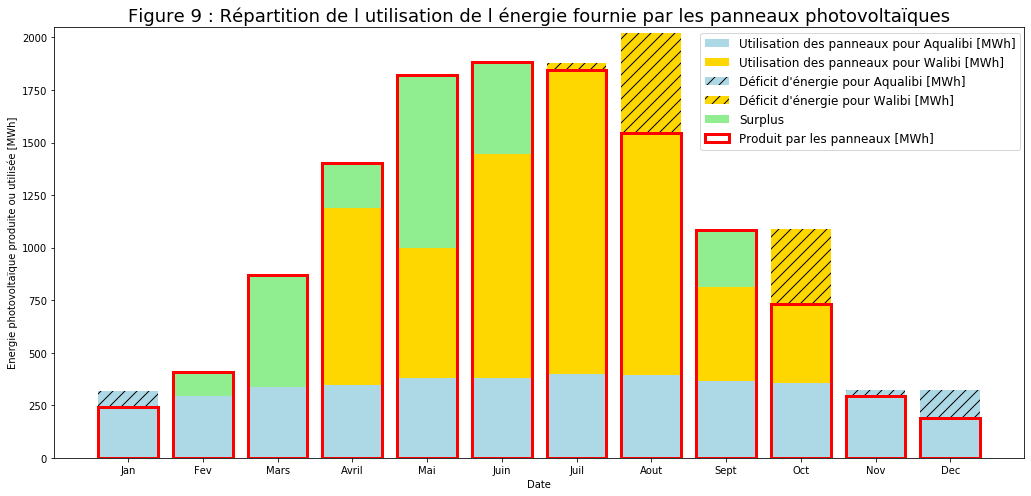

In [23]:
## GRAPHIQUE DE LA REPARTITION D'ENERGIE EN MWh ##############################################################################

# Produit par les panneaux solaires :
Pe_mois_prod_janv = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_janv*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_fev = (24*28/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_fev*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_mars = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_mars*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_avr = (24*30/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_avr*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_mai = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_mai*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_juin = (24*30/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_juin*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_juil = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_juil*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_aout = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_aout*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_sept = (24*30/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_sept*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_oct = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_oct*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_nov = (24*30/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_nov*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois
Pe_mois_prod_dec = (24*31/3600)*Surf_tot*(Rendement_panneaux*data_meteo_ens_heure_dec*(60*60)*Influence_angle_incident)/(10**(6))    #MWh sur le mois

# Demandé par aqualibi :
Pe_mois_aqua_janv = (24*31/3600)*np.mean(Pe_heure_janv)   #MWh pour le mois
Pe_mois_aqua_fev = (24*28/3600)*np.mean(Pe_heure_fev)     #MWh pour le mois
Pe_mois_aqua_mars = (24*31/3600)*np.mean(Pe_heure_mars)   #MWh pour le mois
Pe_mois_aqua_avr = (24*30/3600)*np.mean(Pe_heure_avr)     #MWh pour le mois
Pe_mois_aqua_mai = (24*31/3600)*np.mean(Pe_heure_mai)     #MWh pour le mois
Pe_mois_aqua_juin = (24*30/3600)*np.mean(Pe_heure_juin)   #MWh pour le mois
Pe_mois_aqua_juil = (24*31/3600)*np.mean(Pe_heure_juil)   #MWh pour le mois
Pe_mois_aqua_aout = (24*31/3600)*np.mean(Pe_heure_aout)   #MWh pour le mois
Pe_mois_aqua_sept = (24*30/3600)*np.mean(Pe_heure_sept)   #MWh pour le mois
Pe_mois_aqua_oct = (24*31/3600)*np.mean(Pe_heure_oct)     #MWh pour le mois
Pe_mois_aqua_nov = (24*30/3600)*np.mean(Pe_heure_nov)     #MWh pour le mois
Pe_mois_aqua_dec = (24*31/3600)*np.mean(Pe_heure_dec)     #MWh pour le mois

# Demandé par walibi :
Pe_mois_wab_avr = (7000/1261)*152                                     #MWh pour le mois
Pe_mois_wab_mai = (7000/1261)*112                                     #MWh pour le mois
Pe_mois_wab_juin = (7000/1261)*192                                    #MWh pour le mois
Pe_mois_wab_juil = Pe_mois_prod_juil - Pe_mois_aqua_juil              #MWh pour le mois
Pe_mois_wab_aout = Pe_mois_prod_aout - Pe_mois_aqua_aout              #MWh pour le mois
Pe_mois_wab_sept = (7000/1261)*81                                     #MWh pour le mois
Pe_mois_wab_oct = Pe_mois_prod_oct - Pe_mois_aqua_oct        #MWh pour le mois

# Déficit :
Pe_mois_déficit_janv = Pe_mois_aqua_janv - Pe_mois_prod_janv        #MWh pour le mois
Pe_mois_déficit_nov = Pe_mois_aqua_nov - Pe_mois_prod_nov           #MWh pour le mois
Pe_mois_déficit_dec = Pe_mois_aqua_dec - Pe_mois_prod_dec           #MWh pour le mois

Pe_mois_déficit_wab_juil = (7000/1261)*267-Pe_mois_wab_juil                #MWh pour le mois
Pe_mois_déficit_wab_aout = (7000/1261)*293-Pe_mois_wab_aout                #MWh pour le mois
Pe_mois_déficit_wab_oct = (7000/1261)*132-Pe_mois_wab_oct                  #MWh pour le mois

# Surplus :
Pe_mois_surplus_fev = Pe_mois_prod_fev - Pe_mois_aqua_fev                        #MWh pour le mois
Pe_mois_surplus_mars = Pe_mois_prod_mars - Pe_mois_aqua_mars                     #MWh pour le mois
Pe_mois_surplus_avr = Pe_mois_prod_avr - Pe_mois_aqua_avr - Pe_mois_wab_avr      #MWh pour le mois
Pe_mois_surplus_mai = Pe_mois_prod_mai - Pe_mois_aqua_mai - Pe_mois_wab_mai      #MWh pour le mois
Pe_mois_surplus_juin = Pe_mois_prod_juin - Pe_mois_aqua_juin - Pe_mois_wab_juin  #MWh pour le mois
Pe_mois_surplus_juil = Pe_mois_prod_juil - Pe_mois_aqua_juil - Pe_mois_wab_juil  #MWh pour le mois
Pe_mois_surplus_sept = Pe_mois_prod_sept - Pe_mois_aqua_sept - Pe_mois_wab_sept  #MWh pour le mois

# Graphe :
Pe_mois_prod = [Pe_mois_prod_janv,Pe_mois_prod_fev,Pe_mois_prod_mars,Pe_mois_prod_avr,Pe_mois_prod_mai,Pe_mois_prod_juin,Pe_mois_prod_juil,Pe_mois_prod_aout,Pe_mois_prod_sept,Pe_mois_prod_oct,Pe_mois_prod_nov,Pe_mois_prod_dec]
Pe_mois_aqua = [Pe_mois_aqua_janv,Pe_mois_aqua_fev,Pe_mois_aqua_mars,Pe_mois_aqua_avr,Pe_mois_aqua_mai, Pe_mois_aqua_juin,Pe_mois_aqua_juil,Pe_mois_aqua_aout,Pe_mois_aqua_sept,Pe_mois_aqua_oct,Pe_mois_aqua_nov,Pe_mois_aqua_dec]
Pe_mois_wab = [0,0,0,Pe_mois_wab_avr,Pe_mois_wab_mai,Pe_mois_wab_juin,Pe_mois_wab_juil,Pe_mois_wab_aout,Pe_mois_wab_sept,Pe_mois_wab_oct,0,0]
Pe_mois_déficit = [Pe_mois_déficit_janv,0,0,0,0,0,0,0,0,0,Pe_mois_déficit_nov,Pe_mois_déficit_dec]
Pe_mois_surplus = [0,Pe_mois_surplus_fev,Pe_mois_surplus_mars,Pe_mois_surplus_avr,Pe_mois_surplus_mai,Pe_mois_surplus_juin,0,0,Pe_mois_surplus_sept,0,0,0]
Pe_mois_déficit_walibi = [0,0,0,0,0,0,Pe_mois_déficit_wab_juil,Pe_mois_déficit_wab_aout,0,Pe_mois_déficit_wab_oct,0,0]

mois=["Jan","Fev","Mars","Avril","Mai","Juin","Juil","Aout","Sept","Oct","Nov","Dec"]

plt.figure(figsize=(15,7))
plt.bar(mois,Pe_mois_aqua,color="lightblue",label="Utilisation des panneaux pour Aqualibi [MWh]")
plt.bar(mois,Pe_mois_wab,color="gold",bottom=Pe_mois_aqua,label="Utilisation des panneaux pour Walibi [MWh]")
plt.bar(mois,Pe_mois_déficit,color="lightblue",bottom=Pe_mois_prod,label="Déficit d'énergie pour Aqualibi [MWh]", hatch='//')
plt.bar(mois,Pe_mois_déficit_walibi,color="gold",bottom=np.array(Pe_mois_aqua)+np.array(Pe_mois_wab), label="Déficit d'énergie pour Walibi [MWh]",alpha=1, hatch='//')
plt.bar(mois,Pe_mois_surplus,color="lightgreen",bottom=np.array(Pe_mois_aqua)+np.array(Pe_mois_wab),label="Surplus")
plt.bar(mois,Pe_mois_prod,color="None",label="Produit par les panneaux [MWh]", linewidth=3,edgecolor="red",alpha=1)


plt.legend(loc="lower left",bbox_to_anchor=(0.66,0.7))
plt.rc('legend', fontsize=12)
plt.ylabel('Energie photovoltaïque produite ou utilisée [MWh]')
plt.xlabel('Date')
plt.ylim([0,2050])
plt.title('Figure 9 : Répartition de l utilisation de l énergie fournie par les panneaux photovoltaïques', fontsize=18)
plt.tight_layout()
plt.show()


In [26]:
#%% POSTER PLOT 3
#with plt.style.context('seaborn'):
#    plt.figure(figsize=(15,10))
#    plt.bar(mois,Pe_mois_aqua,color="lightskyblue",label="Aqualibi")
#    plt.bar(mois,Pe_mois_wab,color="gold",bottom=Pe_mois_aqua,label="Walibi")
#    plt.bar(mois,Pe_mois_déficit,color="lightskyblue",bottom=Pe_mois_prod,label="Déficit Aqualibi", hatch='//')
#    plt.bar(mois,Pe_mois_déficit_walibi,color="gold",bottom=np.array(Pe_mois_aqua)+np.array(Pe_mois_wab), label="Déficit Walibi", hatch='//')
#    plt.bar(mois,Pe_mois_surplus,color="aquamarine",bottom=np.array(Pe_mois_aqua)+np.array(Pe_mois_wab),label="Surplus")
#    plt.bar(mois,Pe_mois_prod,color="None",label="Production", linewidth=3,edgecolor="coral")

#    plt.legend(fontsize=28, loc="lower left",bbox_to_anchor=(0,0.57))
#    plt.ylim([0,2000])
#    plt.tight_layout()
#    plt.show()

In [24]:
###%% DéFICITS ET SURPLUS ####

# Déficit Aqualibi :
Pe_tot_déficit = Pe_mois_déficit_janv + Pe_mois_déficit_nov + Pe_mois_déficit_dec
print('Déficit d énergie qu Aqualibi devra payer :',Pe_tot_déficit,'MWh par an réparti de novembre à janvier.')
# Déficit Walibi :
Pe_tot_déficitW = Pe_mois_déficit_wab_aout + Pe_mois_déficit_wab_oct
print('Déficit d énergie que Walibi devra payer :',Pe_tot_déficitW,'MWh par an réparti de avril à octobre.')
# Surplus :
Pe_tot_surplus = Pe_mois_surplus_fev + Pe_mois_surplus_mars + Pe_mois_surplus_avr + Pe_mois_surplus_mai + Pe_mois_surplus_juin + Pe_mois_surplus_juil + Pe_mois_surplus_sept
print('Surplus d énergie  :',Pe_tot_surplus,'MWh par an réparti de février à août.')

Déficit d énergie qu Aqualibi devra payer : 236.5885541292756 MWh par an réparti de novembre à janvier.
Déficit d énergie que Walibi devra payer : 833.6832412795936 MWh par an réparti de avril à octobre.
Surplus d énergie  : 2393.960652878326 MWh par an réparti de février à août.


La *Figure 9* ci-dessus montre la répartition de l'utilisation de la surface de panneaux photovoltaïques installés. Nous considèrons comme première hypothèse que l'objectif premier est Aqualibi et qu'il sera donc la priorité pour l'utilisation de cette électricité verte produite. Nous voyons qu'Aqualibi demandera en été une surface bien moins importante de panneaux puisque ceux-ci seront bien plus productifs dû au grand ensoleillement. Comme l'énergie totale produite par les panneaux augmente fortement en été, la proportion nécessaire par Aqualibi diminue (malgré qu'Aqualibi consomme plus en été). 

L'énergie résiduelle pourra être utilisée par Walibi durant sa période d'ouverture (avril à octobre) et contribuera au total à **89 %** de sa consommation électrique d'avril à août. En juillet, août et octobre, Walibi nécessitera une dépense électrique supplémentaire (834 MWh par an). Il y aura un surplus d'électricité de février à juin et en septembre de 2400 MWh au total alors disponible à d'autres utilisateurs du réseau électrique belge.

En revanche, de novembre à janvier, l'ensoleillement sera trop faible pour que les panneaux photovoltaïques fournissent assez d'énergie à Aqualibi. Il y aura donc un déficit de 237 MWh par an qu'Aqualibi devra puiser sur le réseau et donc payer.


3. **Rentabilité financière et environnementale :**

Enfin, estimons les potentiels gains financiers et environnementaux de cette solution. En plus de produire soi même une grande partie de son énergie, Aqualibi percevra une prime (certificats verts) en aide à ce remaniement environnemental.

In [25]:
#%% Rentabilité : (Source : Energie Plus)
print('RENTABILITE')

Prix_gaz_an = Mch*11.92*5.12*24*365   #11.92 kWh/m3 et 5.12€/kWh pour consommateur I2 (https://energieplus-lesite.be/donnees/couts2/detail-du-prix-du-gaz/)
Prix_elec_an = (Pe_totMa*1000)*11.66    #11.66 €/kWh (7.93 sans taxes) pour un consommateur de classe ID (https://energieplus-lesite.be/donnees/couts2/detail-du-prix-de-l-electricite/)
Prix_tot_an = Prix_gaz_an + Prix_elec_an
print('Le coût actuel pour la régulation de l atmosphere d Aqualibi est d environ',Prix_tot_an,'€ par an')

Prix_elec_anB = (Pe_tot_déficit*1000)*11.66     #11.66 €/kWh
print('Le nouveau coût pour la régulation de l atmosphere d Aqualibi serait d environ',Prix_elec_anB,'€ par an')
Prix_solution = 1.5*Prix_tot
Prime_an = 50*Pe_an_tot # €/an (environ 50€/MWh selon enrgie.wallonie.be )

Temps_rentabilisation = Prix_solution/(Prix_tot_an-Prix_elec_anB+Prime_an)
print('Il faudra donc',Temps_rentabilisation*12,'mois pour rentabiliser cet investissement.')

CO2_produit = Mch*2*24*365 # 2kg CO2/m3 gaz H
print('De plus, cela permettra d éviter une production de',CO2_produit/1000,'Tonnes de CO2 par an.')

RENTABILITE
Le coût actuel pour la régulation de l atmosphere d Aqualibi est d environ 56883333.89485185 € par an
Le nouveau coût pour la régulation de l atmosphere d Aqualibi serait d environ 2758622.541147353 € par an
Il faudra donc 3.091194035200204 mois pour rentabiliser cet investissement.
De plus, cela permettra d éviter une production de 480.61093031728745 Tonnes de CO2 par an.


### 4.2 Etude de l'intérêt d'arrêt du chauffage lorsque le parc est fermé pendant une certaine durée

Aqualibi ferme ses portes chaque année durant une vingtaine de jour au mois de janvier. Nous avons étudié le potentiel intérêt d'arrêter le chauffage lors de cette période.

Les résultats suivants semblent encourageant puisque l'arrêt du chauffage de l'eau pendant 15 jours suivis d'une remontée pendant 5 autres jours permettrait d'économiser près de 47 000 kWh par rapport au chauffage constant pendant ces 20 jours. Néanmoins, comparé aux coûts énergétiques d'Aqualibi à l'année (4210 MWh), cette énergie économisée est en fait ridicule. Certes il y a un gain, mais très faible comparé aux coûts totaux. De plus, il faut noter qu'un arrêt total du chauffage risque d'engendrer d'autres problèmes notamment liés à l'humidité. Il faudra donc toujours maintenir une certaine ventilation qui est un des principal coût du système. Enfin, comme calculé ci-après, le temps nécessaire pour réchauffer l'eau est relativement long à cause de l'inertie thermique de l'eau. 

Aqualibi peut donc effectivement réfléchir à diminuer le chauffage durant les périodes de fermetures mais son arrêt complet n'entraine pas une grande économie d'énergie. Cette solution doit donc sûrement être pratiquée par Aqualibi, mais en plus faible mesure, en diminuant par exemple légèrement le chauffage durant les fermetures (nuits y comprises) et en veillant bien à relancer le système assez tôt pour qu'il ait le temps de chauffer.

In [27]:
#%% Interet de laisser tomber la température :
Nbre_jours = 15       #A optimiser
Temps = Nbre_jours*24 

#Couts pour garder constant :
print('COUTS CHAUFFAGE CONSTANT :') 
Pe_pacX = ((P_cal/COP)/1000)*20*24   #[kWh pour 20 jours]
print('Coûts pour maintenir eau à 28°C pendant 20 jours : ', Pe_pacX, 'kWh.')
Pe_déshumX = np.sum((Pe_déshum.loc['2020-01-01':'2020-01-20'])/1000)
Pe_totX = Pe_déshumX + ((2*0.4*Vi/1000)*24*20)          #kWh
print('ce qui revient avec les coûts de ventilation à', Pe_totX + Pe_pacX,'kWh.')

#Couts pour réchauffer
print('-------------')
print('COUTS ARRET ET RELANCE :') 

#1) Température piscine après 20 jours sans chauffage
print('TEMPERATURES APRES ARRET DE 15 JOURS :') 

#Température intérieure :
Veau = 4480 #Volume d'eau (3200*1.4) m^3
Vair = 50000 #Volume d'air m^3
Vi = 150000           #Débit d'air de ventilation [m^3/h]
Cpw = 0.34             #Capacité volumique de l'air [Wh/m^3.K]
Cpj = 1256 #J/m3.K (air)
Ce = 4200000 #J/m3.K (eau)
T_airi = 29
T_air = 29
T_eaui = 28
T_eau = 28
HR_arret = 0.65
temp_arret = temp_norm.loc['2020-01-01':'2020-01-20']
temp_arret_df = pd.DataFrame(temp_arret)
ens_arret = ens_norm.loc['2020-01-01':'2020-01-20']
ens_arret_df = pd.DataFrame(ens_arret)
hum_arret = hum_norm.loc['2020-01-01':'2020-01-20']
hum_arret_df = pd.DataFrame(hum_arret)
sum = 0


for i in range(Temps):

    ## FLUX eau
    #1.1 Evaporation [kWh]
    S_pool =  3200        #[m^2] Surface des bassins de piscine
    v_int = 0.15          #[m/s] Vitesse du vent en piscine intérieure
    HR = 0.65

    psat_air = np.exp(23.3265-(3802.7/(T_air+273.18))-(472.68/(T_air+273.18))**2)
    HSair = (0.622*psat_air*HR)/(101325-psat_air*HR)
    psat_eau = np.exp(23.3265-(3802.7/(T_eau+273.18))-(472.68/(T_eau+273.18))**2)
    HSeau = (0.622*psat_eau*HR)/(101325-psat_eau*HR)

    P_evapo = (25+19*v_int)*(S_pool*(HSeau-HSair))*0.625*(1/1000)

    #1.2 Rayonnement [kWh] 
    Ur = 3.7         # [W/m²K^4] Coefficient d'emittence de l'eau

    P_rayo = S_pool*Ur*((T_eau/100)**4-(T_air/100)**4)*(1/1000)

    #1.3 Conduction avec parois - à négliger
    #1.4 Convection  [kWh]
    Ue = 7.6         #[W/m²*K] Coefficient de transmission 

    P_con = S_pool*Ue*(T_eau-T_air)*(1/1000)

    #1.5 Somme de toutes les pertes calorifiques de l'eau - [kWh]
    P_cal_arret = P_evapo + P_rayo + P_con

    ## FLUX air 1 : Pertes par murs et toit (conduction) ############################################################
    #2.1 Pertes par les murs internes (murvest) vers les vestiaires [W]
    T_vest = 25                # [°C]  
    P_vest = h_totvest*(T_air-T_vest)*S_murvest*(1/1000) #[kWh] 

    #2.2 Pertes par le toit - [W]       
    T_ext_arret = temp_arret.iloc[i]    # Données climatiques
    P_toit = h_tottoit*(T_air-T_ext_arret)*S_toit*(1/1000)      #[kWh] 

    #2.3 Pertes par les murs qui donnent sur l'extérieur (mur) - [W]              
    P_ext = h_totext*(T_air-T_ext_arret)*S_murext*(1/1000)      #[kWh] 

    #2.4 Pertes totales :
    P_condtot = P_vest + P_toit + P_ext    #[kWh]

    ## FLUX air 2 - Gain par le toit ###########################################################################  
    Rs_arret = ens_arret.iloc[i]     # Radiations solaires en [W/m²] - àpd données climatiques "ens"
    P_ens = S_toit*Rs_arret*SHGC*(1/1000)      #[kWh] 

    ## FLUX air 3 - Ventilation ###########################################################################
    T_vent_arret = T_vent.iloc[i]
    Q_ven_arret = ((P_cal_arret/1000)-(P_condtot/1000)+(P_ens/1000))    # kWh
        

    ## FLUX air TOTAUX : Déperditions calorifiques du batiment ##########################################
    P_bat = P_condtot - P_cal_arret - P_ens + Q_ven_arret # [kWh]   (positif = gains (surtout grace à piscines))

    ### FLUX EAU ###
    # 1. Evaporaton :
    psat_w_arret = np.exp(23.3265-(3802.7/(T_eau+273.18))-(472.68/(T_eau+273.18))**2)
    Pw_arret = psat_w_arret            #[Pa] Pression à saturation à la T° de l'eau (3.812)
    psat_v_arret = np.exp(23.3265-(3802.7/(T_air+273.18))-(472.68/(T_air+273.18))**2)
    Pv_arret = (psat_v_arret*HR_arret) #[Pa] Pression de vapeur saturante au point de rosée à la température de l'air (2.622)
    W_evap_arret = 0.75*S_pool*(Pw_arret-Pv_arret)*(0.089+0.0782*v_int)*3600*(1/Y)       # En kg/h

    # 2. Ventilation out :
    rho_air_arret = ((1-((0.3783*(HR_arret/100)*psat_v_arret)/101325))*101325)/(287.058*(273.15+T_air))  #kg/m3
    HS_ventout_arret = (0.622*psat_v_arret*HR_arret)/(101325-psat_v_arret*HR_arret)
    W_ventout_arret = HS_ventout_arret*rho_air_arret*Vi       #kg/h

    # 3. Ventilation in :    
    W_ventin_arret = W_ventout_arret-W_evap_arret        #kg/h

    ## Humidité air in :  
    psat_ventin_arret = np.exp(23.3265-(3802.7/(T_vent_arret+273.18))-(472.68/(T_vent_arret+273.18))**2)
    HS_ventin_arret = (rho_air_arret*Vi)/W_ventin_arret  
    HR_ventin_arret = (101325*HS_ventin_arret)/((0.622*psat_ventin_arret)+(psat_ventin_arret*HS_ventin_arret))

    ## Puissance élec :
    psat_mel_arret = np.exp(23.3265-(3802.7/(T_vent_arret+273.18))-(472.68/(T_vent_arret+273.18))**2)
    xmel_arret = 0.622*(((HR_ventin_arret/100)*psat_mel_arret)/(101325-((HR_ventin_arret/100)*psat_mel_arret)))
    h_mel_arret = (1.006*T_vent_arret) + (xmel_arret*(2501+1.83*T_vent_arret))
    HR_ext_arret = hum_norm.iloc[i]
    psat_ext_arret = np.exp(23.3265-(3802.7/(T_ext_arret+273.18))-(472.68/(T_ext_arret+273.18))**2)
    rho_out_arret = ((1-((0.3783*(HR_ext_arret/100)*psat_ext_arret)/101325))*101325)/(287.058*(273.15+T_ext_arret))  
    xout_arret = 0.622*(((HR_ext_arret/100)*psat_ext_arret)/(101325-((HR_ext_arret/100)*psat_ext_arret)))
    xin_arret = 0.622*(((65/100)*psat_v_arret)/(101325-((65/100)*psat_v_arret)))  
    Mv_in_arret = 0.8*Vi*rho_air_arret   #kg air humide /h
    Ma_in_arret = Mv_in_arret/(1+xin_arret)   #kg air sec /h
    Mv_out_arret = 0.2*Vi*rho_out_arret    #kg air humide /h
    Ma_out_arret = Mv_out_arret/(1+xout_arret)   #kg air sec /h
    Vi_in_arret = 0.8*Vi*(1/3600)*rho_air_arret     #kg/s
    Vi_out_arret = 0.2*Vi*(1/3600)*rho_out_arret   #kg/s
    T_prémel_arret = ((Vi_in_arret*T_air)+(Vi_out_arret*T_ext_arret))/(Vi_in_arret+Vi_out_arret) #°C
    x_prémel_arret = ((xin_arret*Ma_in_arret) + (xout_arret*Ma_out_arret))/(Ma_in_arret+Ma_out_arret) #kg eau /kg air sec
    rho_prémel_arret = 101325/(461.24*(273.15+T_prémel_arret)*(0.622+x_prémel_arret))   #kg/m3 https://energieplus-lesite.be/theories/enveloppe9/proprietes-materiaux/grandeurs-hygrometriques/
    h_prémel_arret = (1.006*T_prémel_arret) + (x_prémel_arret*(2501+1.83*T_prémel_arret))   #kJ/kg

    Pe_déshum_arret = ((0.2*Vi*rho_prémel_arret)/3600)*abs(h_prémel_arret-h_mel_arret)            #[kWh]

    sum += Pe_déshum_arret

    ### Valeurs résultantes :
    # Température eau résultante :
    T_eau = T_eau - ((P_cal_arret*3600000)/(Veau*Ce))
    # Température air résultante :
    T_air = T_air - ((P_bat*3600000)/(Vair*Cpj))


Pe_tot_arret = sum + (2*0.4*Vi*3600/3600000)          #kWh
T_eauf = T_eau
T_airf = T_air
print('Température résultante eau après 10 jours sans chauffage : ', T_eauf, '°C')
print('Température résultante air après 10 jours sans chauffage : ', T_airf, '°C')

#2) Cout pour rechauffer piscine à 28°C
P_cala_tot = ((Veau * Ce * (T_eaui-T_eauf))/3600000) # [kWh pour 20 jours]

Pe_pacY = (P_cala_tot/COP)  #[kWh pour 20 jours]
print('COUTS RELANCE :') 
print('Coûts pour rechauffer eau à 28°C après un arrêt de 10 jours : ', Pe_pacY, 'kWh.')

# Prix en plus :
print('Mais il faudra continuer à déshumidifier l air pour éviter condensation pendant l arret')
print('cela coutera sur les 20 jours',Pe_tot_arret,'kWh supplémentaires.')
print('Au total, nous avons donc ', Pe_pacY+Pe_tot_arret, 'kWh à payer si on arrête le chauffage des piscines')

# Temps nécessaire pour chauffer :
print('TEMPS DE RELANCE :') 
PuissancePAC = 50 #[kW] Puissance PAC air eau Sensor Solid

Temps_chauf = ((Pe_pacY*3600)/PuissancePAC)/3600   #En h
print('Cela prendra', Temps_chauf,'heures pour ramener la piscine à 28°C')
Temps_chauf_jour = Temps_chauf/24
print('soit', Temps_chauf_jour,'jours')

print('-------------')
print('ECONOMIE TOTALE :') 
Economie = (Pe_totX + Pe_pacX)-(Pe_pacY+Pe_tot_arret)
print('Au total, cela fait une économie de ',Economie,'kWh pour ces 20 jours d arrêt.')


COUTS CHAUFFAGE CONSTANT :
Coûts pour maintenir eau à 28°C pendant 20 jours :  48255.61177687585 kWh.
ce qui revient avec les coûts de ventilation à 206557.6864913377 kWh.
-------------
COUTS ARRET ET RELANCE :
TEMPERATURES APRES ARRET DE 15 JOURS :
Température résultante eau après 10 jours sans chauffage :  23.262007920150648 °C
Température résultante air après 10 jours sans chauffage :  20.04165601676919 °C
COUTS RELANCE :
Coûts pour rechauffer eau à 28°C après un arrêt de 10 jours :  6190.97631766982 kWh.
Mais il faudra continuer à déshumidifier l air pour éviter condensation pendant l arret
cela coutera sur les 20 jours 153104.43330975052 kWh supplémentaires.
Au total, nous avons donc  159295.40962742033 kWh à payer si on arrête le chauffage des piscines
TEMPS DE RELANCE :
Cela prendra 123.8195263533964 heures pour ramener la piscine à 28°C
soit 5.159146931391517 jours
-------------
ECONOMIE TOTALE :
Au total, cela fait une économie de  47262.27686391736 kWh pour ces 20 jours d arr

### 5. Sources :

- Energie Plus
- Thermexcel


- https://afim-dehumidifier.com/fr/mollier-calculator-fr/
- https://energieplus-lesite.be/theories/enveloppe9/proprietes-materiaux/grandeurs-hygrometriques/
- https://www.deleze.name/marcel/physique/rosee/masse-vol.html
- http://tonepi.com/systemes-energetiques/caisson-de-melange-dune-centrale-de-traitement-dair-cta.html
- http://tonepi.com/systemes-energetiques/refroidissement-et-deshumidification-de-lair-diagramme-psychrometrique-exemple-de-calcul.html
- https://www.researchgate.net/profile/Olivier-Marc/publication/335570341_Identification_et_etude_de_sensibilite_du_modele_d%27evaporation_sur_l%27evolution_de_la_temperature_de_l%27eau_d%27une_piscine_collective_en_milieu_tropical/links/5d6e153692851c8538889c96/Identification-et-etude-de-sensibilite-du-modele-devaporation-sur-levolution-de-la-temperature-de-leau-dune-piscine-collective-en-milieu-tropical.pdf
- https://www.researchgate.net/profile/Olivier-Marc/publication/335570341_Identification_et_etude_de_sensibilite_du_modele_d%27evaporation_sur_l%27evolution_de_la_temperature_de_l%27eau_d%27une_piscine_collective_en_milieu_tropical/links/5d6e153692851c8538889c96/Identification-et-etude-de-sensibilite-du-modele-devaporation-sur-levolution-de-la-temperature-de-leau-dune-piscine-collective-en-milieu-tropical.pdf
- https://www.thermexcel.com/french/program/piscine.htm



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=13bb5714-8df9-494d-94f1-6dc4bbee23d0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>